![CC](https://i.creativecommons.org/l/by/4.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

# Introduction to machine learning

In this notebook, we cover the following topics:

- Floating point numbers  
  - The IEEE 754 standard  
  - Roundoff error  
  - Truncation error  
- Exploring parameters spaces  
- Generating data with simulations  
- Normalizing data  
- Feature selection and design  
- Deep learning  
  - Test case overview
  - Simple feed-forward neural networks  
  - Preparing the datasets
  - Generic training loop  
  - Training with batches of data
  - Learning rate adjustment
  - Activation functions
  - Advanced building blocks
  - Dealing with uncertainty  
  - Visualizing prediction errors  

**Note:** if you receive an import error related to the *paraview* module when executing the cell below, update the version of flowTorch as follows:
```
# enter the Python environment
source ml-cfd/bin/activate
# remove the old version of flowTorch
pip uninstall flowtorch
# install the latest version
pip install git+https://github.com/FlowModelingControl/flowtorch.git@aweiner
```

In [1]:
from glob import glob
from typing import List, Tuple
from os.path import isdir, join
from shutil import copy
from copy import deepcopy
from time import time
from collections import defaultdict
import numpy as np
import torch as pt
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
from flowtorch.data import FOAMDataloader

# make results reproducible
pt.manual_seed(0)

# increase plot resolution
plt.rcParams["figure.dpi"] = 160

# create output directory
output = "output"
!mkdir -p $output

Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.


## Floating point numbers

You might be wondering why a lecture about ML starts with a section on floating point numbers. The answer is that a good understanding of how floating point numbers work often helps avoiding pitfalls both in ML and CFD. Computers can not represent real numbers with arbitrary precision, and when designing and implementing numerical algorithms, using the available precision effectively can make the difference between success and failure.

### The IEEE 754 standard and roundoff error

Floating point numbers are the digital representation of real numbers. The IEEE 754 standard defines how exactly most modern computers represent floating point numbers in terms of bits. One bit is always reserved for the sign $S$, and the remaining bits are shared by an integer exponent $E$ and a binary [mantissa](https://en.wikipedia.org/wiki/Significand) $M$. Using these three components, floating point numbers are written as (refer to chapter 1.1.1 in *Numerical Recipes*):
$$
  S \times M \times 2^{E-e},
$$
where $e$ is a fixed machine-dependent constant. In CFD and scientific computing in general, 64 bit floating point numbers are the standard, whereas most ML libraries use 32 bit floating point values by default. Floating point numbers with 32 bit are referred to as *single precision*, and the 64 bit counterpart is termed *double precision*. Single precision operations are more efficient, whereas double precision provides more significant decimal digits. The smallest number that can be still represented by the floating point type on our computer if we add it to $1.0$ is called *machine tolerance*. We can use the NumPy library function [finfo](https://numpy.org/doc/stable/reference/generated/numpy.finfo.html) to investigate mantissa, exponent, and machine tolerance for the most common data types *float32* and *float64*.

In [76]:
for dtype in [np.float32, np.float64]:
    finfo = np.finfo(dtype)
    print(f"dtype: {finfo.dtype}")
    print(f"Number of bits: {finfo.bits}")
    print(f"Bits reserved for mantissa: {finfo.nmant}")
    print(f"Bits reserved for exponent: {finfo.iexp}")
    print("Largest representable number: {:e}".format(finfo.max))
    print("Smallest representable number: {:e}".format(finfo.min))
    print("Machine tolerance: {:e}".format(finfo.eps))
    print(f"Approximately accurate up to {finfo.precision} decimal digits")
    print("-"*46)

dtype: float32
Number of bits: 32
Bits reserved for mantissa: 23
Bits reserved for exponent: 8
Largest representable number: 3.402823e+38
Smallest representable number: -3.402823e+38
Machine tolerance: 1.192093e-07
Approximately accurate up to 6 decimal digits
----------------------------------------------
dtype: float64
Number of bits: 64
Bits reserved for mantissa: 52
Bits reserved for exponent: 11
Largest representable number: 1.797693e+308
Smallest representable number: -1.797693e+308
Machine tolerance: 2.220446e-16
Approximately accurate up to 15 decimal digits
----------------------------------------------


### Roundoff error

We can run a small experiment to observe the consequences of the limited machine tolerance in practice. The floating point data types in PyTorch are named in the same fashion as their NumPy counterparts.

In [77]:
a = pt.tensor(1.0, dtype=pt.float32)
for b in [10**i for i in range(-1, -11, -1)]:
    print("1.0 + {:1.1e} = {:10.10f}".format(b, a+b))

1.0 + 1.0e-01 = 1.1000000238
1.0 + 1.0e-02 = 1.0099999905
1.0 + 1.0e-03 = 1.0010000467
1.0 + 1.0e-04 = 1.0001000166
1.0 + 1.0e-05 = 1.0000100136
1.0 + 1.0e-06 = 1.0000009537
1.0 + 1.0e-07 = 1.0000001192
1.0 + 1.0e-08 = 1.0000000000
1.0 + 1.0e-09 = 1.0000000000
1.0 + 1.0e-10 = 1.0000000000


In the print statement above, we display the result with 10 decimal digits. However, the *float32* type offers only up to 7 significant digits. All additional digits are filled up with somewhat random numbers. Moreover, when adding values like $10^{-8}$ and smaller, the added small fraction falls victim to the **roundoff** error. After seeing the small experiment above, adding a value in the order of $O(10^{-8})$ to another value that is $O(1)$ will hopefully trigger your roundoff alarm sirens. However, the difficulty with numerical precision is not always so apparent. Consider some points $(x_i, y_i)$ with $-0.01\le x \le 0.01$ and $1 \le y \le 10$. Now, we want to fit a polynomial to our data, say $y(x) = ax^4+bx^3+cx^2+dx+e$, so we construct the necessary polynomial features by computing the corresponding powers of $x$. The constants are determined using some gradient-based iterative algorithm like gradient decent. At the beginning of the optimization, the weights (coefficients) $a$ to $e$ are typically initialized by sampling random numbers between zero and one. Considering the polynomial form again, most likely the optimization will be affected by roundoff errors (using single precision) because the first term $ax^4$ will be always smaller than $10^{-8}$ and the last term $e$ will be $O(1)$. In practice, we can mitigate such scenarios to some extend by normalizing the data, as we will learn later on in this notebook.

In [78]:
for x in pt.arange(-0.01, 0.011, 0.0025):
    print("x={:+1.4e}, x**2={:1.4e}, x**3={:+1.4e}, x**4={:1.4e}".format(x, x**2, x**3, x**4))

x=-1.0000e-02, x**2=1.0000e-04, x**3=-1.0000e-06, x**4=1.0000e-08
x=-7.5000e-03, x**2=5.6250e-05, x**3=-4.2187e-07, x**4=3.1641e-09
x=-5.0000e-03, x**2=2.5000e-05, x**3=-1.2500e-07, x**4=6.2500e-10
x=-2.5000e-03, x**2=6.2500e-06, x**3=-1.5625e-08, x**4=3.9062e-11
x=+0.0000e+00, x**2=0.0000e+00, x**3=+0.0000e+00, x**4=0.0000e+00
x=+2.5000e-03, x**2=6.2500e-06, x**3=+1.5625e-08, x**4=3.9062e-11
x=+5.0000e-03, x**2=2.5000e-05, x**3=+1.2500e-07, x**4=6.2500e-10
x=+7.5000e-03, x**2=5.6250e-05, x**3=+4.2187e-07, x**4=3.1641e-09
x=+1.0000e-02, x**2=1.0000e-04, x**3=+1.0000e-06, x**4=1.0000e-08


In iterative solution algorithms, roundoff errors can be even more challenging. Consider the following two operations, in which we get a roundoff error because the intermediate result, $1/3$ can't be represented exactly as a binary number:

In [79]:
a = pt.tensor(1.0)
print("a={:1.10f}".format(a))
b = a - 2.0/3.0
print("b={:1.10f}".format(b))
a = 3.0*b
print("a={:1.10f}".format(a))

a=1.0000000000
b=0.3333333135
a=0.9999999404


Now let's simulate an simplified iterative solution algorithm, in which we execute the same options many times in a row:

In [80]:
def iterate(n_iter: float = 1):
    a = pt.tensor(1.0)
    for _ in range(n_iter):
        b = a - 2/3
        a = 3.0 * b
    print(f"a={a:1.10f} after {n_iter:1d} iteration(s)")

for i in range(1, 10):
    iterate(i)

a=0.9999999404 after 1 iteration(s)
a=0.9999997616 after 2 iteration(s)
a=0.9999992251 after 3 iteration(s)
a=0.9999976158 after 4 iteration(s)
a=0.9999927878 after 5 iteration(s)
a=0.9999783039 after 6 iteration(s)
a=0.9999348521 after 7 iteration(s)
a=0.9998044968 after 8 iteration(s)
a=0.9994134307 after 9 iteration(s)


The discrepancy between single precision in ML and double precision in CFD is usually not critical, especially if ML is used as a means of post-processing CFD data. The situation might change if the ML model is employed somewhen during the simulation's runtime. A save option is setting the default precision of the ML library to double precision. In PyTorch, this option can be set globally at the beginning of the program.

In [81]:
x = pt.tensor(1.0)
print(x.dtype)
pt.set_default_dtype(pt.float64)
x = pt.tensor(1.0)
print(x.dtype)
pt.set_default_dtype(pt.float32)

torch.float32
torch.float64


## Truncation error

In contrast to the roundoff error, the truncation error is not a hardware property but results from the discrete approximation of continuous quantities. For example, we could approximate the integral of $y(x) = x^2$:
$$
  \int\limits_0^1 x^2 \mathrm{d}x = 1/3
$$
numerically by using the trapezoidal rule.

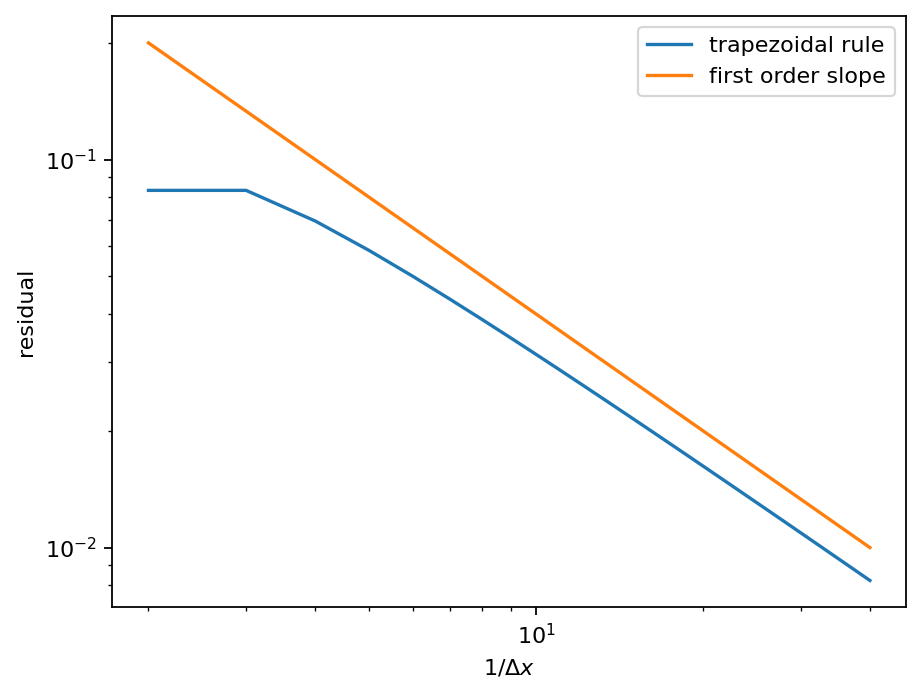

In [82]:
max_intervals = 40
residual = []
for n_int in range(2, max_intervals+1):
    x = pt.linspace(0, 1, n_int)
    y = x**2
    dx = (1.0-0.0) / n_int
    integral = 0.5 * (y[0:-1]+y[1:]).sum() * dx
    residual.append(abs(integral - 1.0/3.0))

plt.plot(range(2, max_intervals+1), residual, label="trapezoidal rule")
plt.plot([2, max_intervals], pt.tensor([max_intervals, 2])*(0.005), label="first order slope")
plt.xlabel(r"$1/\Delta x$")
plt.ylabel("residual")
plt.xscale("log")
plt.yscale("log")
#plt.gca().set_aspect("equal")
plt.legend()
plt.savefig(f"{output}/residual_trapezoidal_rule.svg", bbox_inches="tight")

As we can see, the residual decreases proportionally to the size of discrete elements into which we divide the interval. So, even if the computer provided perfect accuracy, it would still take infinitely small elements to reach perfect accuracy. CFD simulations employing the finite volume method are typically second order accurate, so the truncation error decreases proportionally to the square of the element size.

## Exploring parameter spaces

Suppose we want to conduct a CFD parameter study in which we vary the Reynolds number $Re$ and record the drag coefficient $c_d$. Our aim would be to create an ML-based surrogate model based on the pairs $Re_i$ and $c_{d,i}$. Let's assume we know a range for $Re$ that we are particularly interested in. An important question before starting the simulations is now how to pick suitable $Re$ values in the specified range. In general, we want our sampling to be:

1. unbiased - every point has the same chance of being selected
2. efficient - we want to run as few simulations as possible
3. homogeneous - we want the samples to be homogeneously distributed across the parameter space

Let's say we want to run $N_s$ simulations. Intuitively, you may want to distribute the $N_s$ points equally spaced across the Reynolds number range, and there are good arguments to do so. However, there are at least two problems with this approach:

1. it does not scale to multiple dimensions, e.g., if we vary more than one parameter; if we want to treat every parameter equal, we should pick $N_s$ points in every parameter range and perform simulation for all parameter permutations; for $d$ parameters, this strategy would require running $N_s^d$ simulations; the number of sample points increases exponentially
2. it is biased because not every point has the same chance of being sampled; the plot below show a somewhat artificial and extreme effect of bias; the true signal is periodic but the samples suggest that there is basically no correlation between input and output

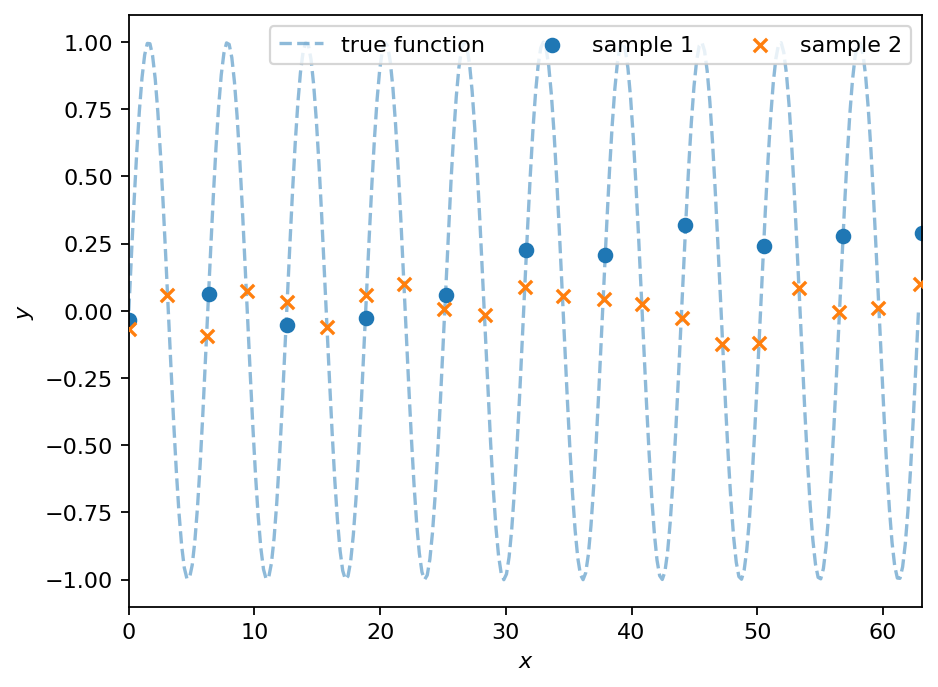

In [83]:
x = pt.linspace(0.0, 20*np.pi, 300)
y = pt.sin(x)

x_sample_1 = pt.linspace(0, 20.1*np.pi, 11) + (2*pt.rand(11)-1)*0.1
x_sample_2 = pt.linspace(0, 20*np.pi, 21) + (2*pt.rand(21)-1)*0.1

plt.plot(x, y, alpha=0.5, ls="--", label="true function")
plt.scatter(x_sample_1, pt.sin(x_sample_1) +
            (2*pt.rand(11)-1)*0.05, label="sample 1")
plt.scatter(x_sample_2, pt.sin(x_sample_2) + (2*pt.rand(21)-1)
            * 0.05, marker="x", label="sample 2", zorder=6)
plt.xlim(0, 20.1*np.pi)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend(ncol=3, loc=1)
plt.savefig(f"{output}/biased_sampling.svg", bbox_inches="tight")

To make the samples unbiased, we should select the samples randomly. However, selecting $N_s$ points at random may give you some stomach ache, too, because large portions of the parameter space might remain unexplored. Random sampling is relatively inefficient.

A good compromise between the homogeneity of equally spaced sample points and efficient unbiased sampling is *latin hypercube sampling* (LHS). If the goal is to perform $N_s$ simulations, each parameter range is equally divided into $N_s$ sections. Then, one random sample is drawn in each section of each parameter. If there is more than one parameter, the samples drawn from the individual parameter ranges are shuffled. Combining (stacking) the shuffled individual samples yields the final samples in the full parameter space. Below, we implement a simple version of LHS in PyTorch. 

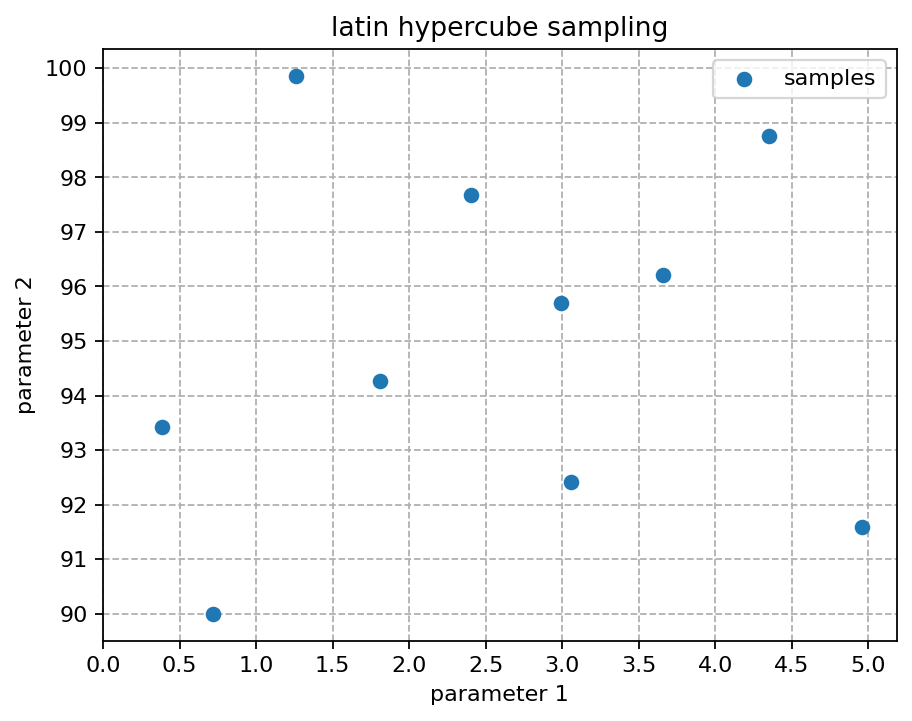

In [84]:
def lhs_sampling(x_min, x_max, n_samples):
    assert len(x_min) == len(x_max)
    n_parameters = len(x_min)
    samples = pt.zeros((n_parameters, n_samples))
    for i, (lower, upper) in enumerate(zip(x_min, x_max)):
        bounds = pt.linspace(lower, upper, n_samples+1)
        rand = bounds[:-1] + pt.rand(n_samples) * (bounds[1:]-bounds[:-1])
        samples[i, :] = rand[pt.randperm(n_samples)]
    return samples


N_s = 10
samples = lhs_sampling([0, 90], [5, 100], N_s)
plt.scatter(samples[0, :], samples[1, :], zorder=6, label="samples")
plt.xticks(pt.linspace(0, 5, N_s+1))
plt.yticks(pt.linspace(90, 100, N_s+1))
plt.grid(True, ls="--")
plt.legend()
plt.xlabel("parameter 1")
plt.ylabel("parameter 2")
plt.title("latin hypercube sampling")
plt.savefig(f"{output}/lhs_sampling.svg", bbox_inches="tight")

## Generating data from simulations

The previous section covered how to sample a parameter space efficiently and unbiased. This section outlines some tools and strategies to run automated CFD parameter studies. Every parameter study should start with a tested and validated base simulation. Typical criteria for a good base simulation are similar to the ones of any good CFD simulation:

- the setup correctly reflects the mathematical problem
- a mesh dependency study was performed, and the results show sufficiently low mesh dependency
- key performance quantities were validated against high-fidelity reference data
- the setup is optimized; mesh-independent results are obtained as quickly as possible

The easiest way to perform a parameter study is to create a copy of the base simulation, modify the parameters in question, and run the new setup. However, the change of one parameter often requires the adjustment of related settings, too. For example, increasing the inlet velocity or the pressure gradient driving the flow leads to an increased Courant number if the mesh remains unchanged. Since the increased Courant number might cause stability issues, the numerical time step should be lowered. Tools like OpenFOAM support time step adjustment based on the maximum Courant number, which simplifies parameter changes to some extend. If the time step needs adjustment, the characteristic time scale of the problem has probably changed, too. For example, the vortex shedding frequency displayed by the flow past a cylinder increases proportionally to the Reynolds number in the range $80 < Re < 1000$. If our aim is to run the simulation until a quasi-steady vortex shedding is reached, the required physical simulation time decreases as the Reynolds number increases. Running all simulation up to the same physical end time would be a waste of resources.

On the other hand side, changing too many parameters at once might make the setup unnecessarily complex and could introduce unforeseeable side effects. Mesh generation, for example, is often an intricate and time consuming process, such that we may want to run all simulations employing the same mesh. However, how do we ensure that the results remain mesh independent despite an increase, say, of the Reynolds number? A simple strategy for this scenario would be to pick the most demanding case in terms of mesh resolution and to build the mesh based on this configuration. Of course, the computational efficiency for less demanding cases decreases, but building optimized meshes for all conditions might be untractable.

Once the base case is ready, we can write a script that copies, modifies, and runs new setups. Shell or Python scripts are good choices to automate the process. Shell programming is a good option for simple parameter variations and to automate workflows in general. The *Allrun* scripts provided in the *test_cases* are simple recipes to perform a list processing steps required to perform the simulation. Python scripts are more powerful but require a Python interpreter and possibly additional library dependencies. Python also allows executing shell commands via the standard library functions [os.system()](https://docs.python.org/3/library/os.html#os.system) or [subprocess.Popen()](https://docs.python.org/3/library/subprocess.html#subprocess.Popen). The *system* function is rather limited but sufficient for running simple and short shell commands. For example, the lines
```
cmd = "sed -i 's/old_text/new_text/' exampleDict"
os.system(cmd)
```
would search the file *exampleDict* for the string *old_text* and replace the text with *new_text*. On the other hand side, *Popen* offers greater flexibility in terms of process control. The same command as above executed with *subprocess* would be:

```
cmd = ["sed", "-i", "'s/old_text/new_text/'", "exampleDict"]
p = subprocess.Popen(cmd)
# print exit code to check if execution was successful
print(p.poll())
```

In the case of OpenFOAM simulations, the *Popen* function is a good candidate to perform individual simulations:

```
def run_simulation(path: str):
    """Execute a simulation by running the *Allrun* script.

    :param path: path to simulation folder
    :type path: str
    """
    return_code = Popen(["./Allrun"], cwd=path).wait()
    if return_code == 0:
        print(f"Simulation {path} completed successfully.")
    else:
        print(f"Warning: simulation {path} failed.")
```
If we had a list of paths to modified simulations, we could loop over the list and use the *run_simulation* function to execute one simulation after the other. We can accelerate the execution process if we have enough resources to perform multiple simulations at once. Python supports running multiple processes at once via the *multiprocessing* module. A suitable workflow making use of the *run_simulation* function defined before, would be to create a process pool based on the number of available CPU cores and to map all the list of all simulation paths to the *run_simulation* function:
```
simulations = ["./sim_0/", "./sim_1/", "./sim_2/"]
pool = Pool(2)
with pool:
    pool.map(run_simulation, simulations)
```
Employing the code snippet above, simulations zero and one would be run roughly at the same time. Whichever subprocess finishes first will then execute simulation two.

## Normalizing data

Suppose we created a dataset, in which an airfoil's drag coefficient was determined for several Reynolds numbers $Re$ and angles of attack $\alpha$. The Reynolds number ranges between $Re=10\times 10^6$ and $Re=20\times 10^6$. The angle of attack was varied between $\alpha = 0^\circ$ and $\alpha = 4^\circ$. Now we want to build a surrogate model by means of regression. Based on section 1, it should be clear that combining the features $Re$ and $\alpha$ directly in a model is not a good idea. So, how can we improve the situation? A simple solution is to normalize both features. There are two common ways to normalize any kind of data. In a min-max-scaling, each feature $x_i$ are scaled to the range $[0,1]$:
$$
  \tilde{x}_i = \frac{x_i-x_{i,min}}{x_{i,max}-x_{i,min}}.
$$
Alternatively, the equation above could also be rescaled to the range $[-1,1]$. Min-max scaling works great if the input data are clean, e.g., if there are no outliers. A normalization technique less sensitive to outliers scales the features with their mean $\mu_x$ and standard deviation $\sigma_x$:
$$
  \tilde{x}_i = \frac{x_i-\mu_{x_i}}{\sigma_{x_i}}.
$$
The re-scaled features have zero mean and unit standard deviation. These properties are also the reason why this scaling is a good choice when training neural networks employing sigmoid and hyperbolic tangents activation functions. These activation functions are not so popular any longer in most fields using deep learning. However, for PINNs they are essential because one can compute arbitrarily many derivatives of both functions. Without going further into detail about neural networks, it is sufficient to now that we do not want activation functions to *saturate*, which mean to become insensitive to the input. Looking at the sigmoid function depicted below, saturation occurs if the argument becomes too small or too low. Data normalized by their mean and standard deviation lead to activation values in the most sensitive range (the slope is the highest around $x=0$).

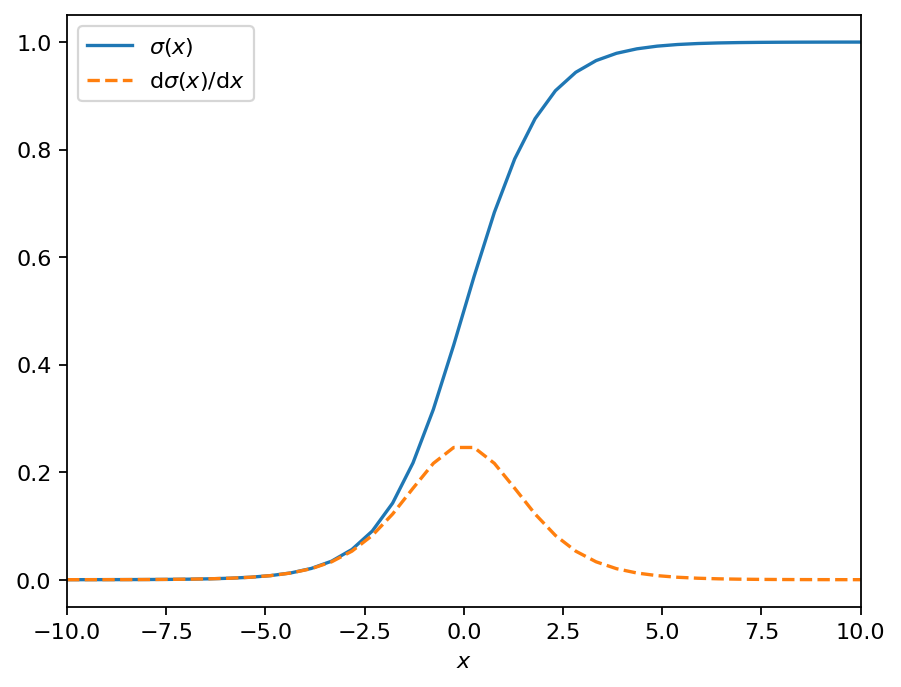

In [85]:
def sigmoid(x: pt.Tensor) -> pt.Tensor:
    """Compute the sigmoid function.

    :param x: input argument
    :type x: pt.Tensor
    :return: sigmoid of x
    :rtype: pt.Tensor
    """
    return 1.0 / (1.0 + pt.exp(-x))


x = pt.linspace(-10, 10, 40)
plt.plot(x, sigmoid(x), label=r"$\sigma (x)$")
plt.plot(x, sigmoid(x)*(1.0-sigmoid(x)), ls="--",
         label=r"$\mathrm{d}\sigma (x)/\mathrm{d} x$")
plt.xlabel(r"$x$")
plt.xlim(-10, 10)
plt.legend()
plt.savefig(f"{output}/sigmoid_function.svg", bbox_inches="tight")

Clustering is another great example to demonstrate the importance of normalization. Suppose we have the following data points for Reynolds number $Re$ and lift coefficient $c_l$:

| $i$ | $Re$ | $c_l$ |
|:---:|:----:|:--------:|
| 1 | $10\times 10^6$ | $0.3$ |
| 2 | $12\times 10^6$ | $0.12$ |
| 3 | $15\times 10^6$ | $0.11$ |

Clustering is about grouping similar data points. Eyeballing the data, you probably see that something significant must have happened in the range $10\times 10^6 < Re < 12\times 10^6$ because the lift dropped to about one third for the measurement points 2 and 3. If you were tasked to sort similar data points into two different bins, you would probably separate point 1 from the points 2 and 3. To automate the clustering, we need a more precise definition of the notion of similarity we used so far. The most common metric to measure the distance between data points is the [Euclidean norm](https://en.wikipedia.org/wiki/Euclidean_distance). For the data point above, the distances are:

| points | distance |
|:------:|:--------:|
| 1-2 | $2\times 10^6$ |
| 1-3 | $5\times 10^6$ |
| 2-3 | $3\times 10^6$ |

According to the Euclidean distance, we should rather group points 1 and two together because the distance between them is the smallest. Of course, this outcome is not really what we wanted. Again, normalization can help the situation. The min-max-normalized data are:

| $i$ | $\tilde{Re}$ | $\tilde{c}_l$ |
|:---:|:----:|:--------:|
| 1 | $0$ | $1$ |
| 2 | $0.4$ | $0.05$ |
| 3 | $1$ | $0$ |

The distances between the points are now:

| points | distance |
|:------:|:--------:|
| 1-2 | $1.03$ |
| 1-3 | $1.41$ |
| 2-3 | $0.60$ |

This time, the distance reflects out initial evaluation. The distance between points 2 and 3 is the smallest. In higher dimensions, seeing such normalization-related issue is not straight forward. Therefore, it is good practice to **always** normalize all the data, features as well as labels. In the worst case, normalization costs you a few extra operations to scale and re-scale the model's input and output. In most cases, normalization improves accuracy and accelerates the training.

Finally, if the data points of a feature are very unevenly distributed in the feature space, it might be sensible to work with the logarithm of the feature instead of the feature itself. An example displaying the usefulness of logarithmic scaling is part of the next lecture.

## Feature selection and design

Selecting and designing good features is one of the most essential parts of applying ML to CFD problems. Sometimes, the features and labels are naturally given, and it is straight forward to identify the mapping that the ML model has to perform. Suppose we have a car model and want to create a surrogate model predicting the drag as a function of the Reynolds number based on a couple of CFD simulations. In the simulation, the inlet velocity may be defined to impose a certain Reynolds number und the aerodynamic forces acting on the car result from the velocity and pressure fields. There would be only one feature and one label, and we could choose from a variety of regression algorithms to build a suitable surrogate model. However, sometimes it can be sensible to design additional features based on the extracted raw data. Potential reasons for designing new features could be:

- to enforce mathematical constraints like symmetry or boundedness
- to leverage known (physical) relations
- to reduce the variance in the data before training

In summary, one could say that feature design serves the purpose to simplify the ML problem. Good features accelerate the model training and often lead to smaller yet more accurate models. However, care has to be taken when selecting or designing features. It is essential to know right from the beginning what exactly the model is going to be used for in a target application. One common pitfall is basing the model on features that are not (easily) available in the target application. For example, when deriving models for low-fidelity simulations based on high fidelity data, we must first convert the high-fidelity data into features that are also available during the runtime of the low-fidelity simulation. To give a more specific example, direct numerical simulations (DNS) data may be used for turbulence modeling in large eddy simulation (LES) or Reynolds-averaged Navier-Stokes (RANS) simulation approaches. In all approaches, there is going to be a *velocity field*. However, the mathematical definition of velocity and other quantities varies in each simulation. DNS provides spatially and temporally resolved fields, while LES works with filtered and RANS with time-averaged information. Therefore, the first processing step should be to filter or average the DNS data before exploring and designing new features. Not only the mathematical definition of features but also assumptions about the spatial arrangement might be important. For example, DNS solvers might operate on structured Cartesian meshes, while solver for industrial applications operate on unstructured meshes with arbitrary topology. While it might seem a good idea at first to use specialized neural network architectures like convolutional neural networks to process the array-like DNS data, such a model would be hard or even impossible to apply in the unstructured target solver.

A general rule of thumb for designing additional features is to have rather too many than too few features. Not all features should and will be used for model training since the model may become unnecessary complex or prone to over-fitting the data. However, instead of eliminating features manually, one could consider employing feature exploration and selection strategies. Some examples are:

 - [correlation heatmaps](https://stackoverflow.com/questions/39409866/correlation-heatmap) visualize the linear correlation between different features and labels; if the correlation between a feature and a label is strong, the feature might be a good candidate for modeling
 - sequential forward/backward selection performs eliminatory rounds with varying numbers and combinations of features; each round, one feature is removed (backward selection) or added (forward selection)
 - decision trees or ensemble variants thereof have a built-in [feature importance](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) to rank features (based on the internal criteria at each node of the tree)
 - [permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance) shuffles the values of a single feature randomly and observes how the performance of a training model is affected

 The feature ranking strategies have different pros and cons. Sequential backward selection, for example, yields a meaningful ranking in most cases but can be very expensive to compute. Decision trees, on the other hand, are easily trained, but their *feature importance* is more susceptible to small changes in the data.

## Deep learning

### Test case overview

To demonstrate the training and evaluation of neural networks, we need some training data. Here, we work with developed velocity profiles of a 1D channel flow simulation. Conducting the parameter study to create the data is part of the accompanying exercise session. The channel flow is characterized by the Reynolds number $Re=2\delta\bar{U}/\nu$, where $\delta$ is one half of the channel height, $\bar{U}$ is the average velocity along the channel, and $\nu$ is the kinematic viscosity. In the parameter study, 16 different values $ 10^4 < Re < 10^5$ were sampled with latin hypercube sampling and the corresponding simulations executed. The main output of a single simulation is the velocity along the channel $u_x$ at several distances $y$ normal to the channel wall. Our goal is creating a model that provides us with the normalized streamwise velocity $\tilde{u}_x = u_x/\bar{U}_{max}$ value for a given normalized distance from the wall $\tilde{y} = y/(2\delta)$ and the Reynolds number:
$$
  \tilde{u}_{x} = f_\theta(\tilde{y}, Re).
$$
The features are $\tilde{y}$ and $Re$. The label is $\tilde{u}_x$. Such a model could be the basis for improving the accuracy of the near wall region of turbulent flow simulations. Note that there are more clever ways to normalize $y$ and $u_x$, but we stick to the version above to make the learning slightly more challenging.

As a first step, we load the velocity profiles, the points normal to the wall at which the velocity values are defined, and the Reynolds numbers.

In [2]:
cases = glob("../exercises/boundary_layer_1D_variation/Ub_*")
cases = sorted(cases, key=lambda case: float(case.split("_")[-1]))
loader = FOAMDataloader(cases[0])
y = loader.vertices[:, 1]
u_x = pt.zeros((y.shape[0], len(cases)))
for i, case in enumerate(cases):
    loader = FOAMDataloader(case)
    u_x[:, i] = loader.load_snapshot("U", loader.write_times[-1])[:, 0]

Ubar = pt.tensor([float(case.split("_")[-1]) for case in cases])
print("Shape of data matrix: ", u_x.shape)

Could not find precomputed cell centers and volumes.
Computing cell geometry from scratch (slow, not recommended for large meshes).
To compute cell centers and volumes in OpenFOAM, run:

postProcess -func "writeCellCentres" -constant -time none
postProcess -func "writeCellVolumes" -constant -time none
Shape of data matrix:  torch.Size([200, 16])


There are 200 points normal to the wall and 16 different Reynolds numbers. Each velocity profile contains 200 values and all 16 profiles assembled yield a $200\times 16$ tensor. Since the data are low-dimensional, we have the luxury of being able to visualize the full dataset all at once.

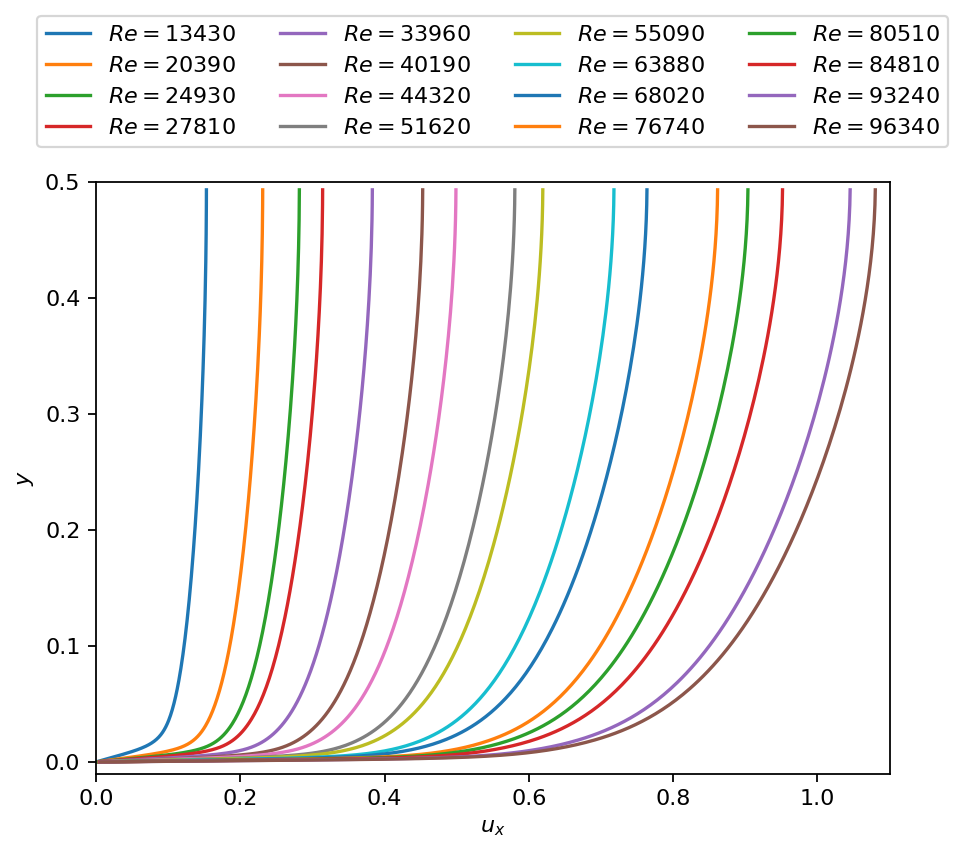

In [3]:
delta, nu = 0.5, 1.0e-5
Re = pt.tensor([Ub.item()*2*delta/nu for Ub in Ubar])
for i in range(len(Re)):
    plt.plot(u_x[:, i], y, label=r"$Re={:1.0f}$".format(round(Re[i].item(), 0)))
plt.xlabel(r"$u_x$")
plt.ylabel(r"$y$")
plt.xlim(0.0, 1.1)
plt.ylim(-0.01, 0.5)
plt.legend(loc="upper center", ncol=4, bbox_to_anchor=[0.5, 1.3])
plt.savefig(f"{output}/developed_1d_profile.svg", bbox_inches="tight")

The normalization visualized does not alter the nature of the data significantly. However, if $y$ and $u_x$ had very different values ranges, normalizing by the channel height and the average velocity would bring both quantities much closer to the desired range about $O(1)$.

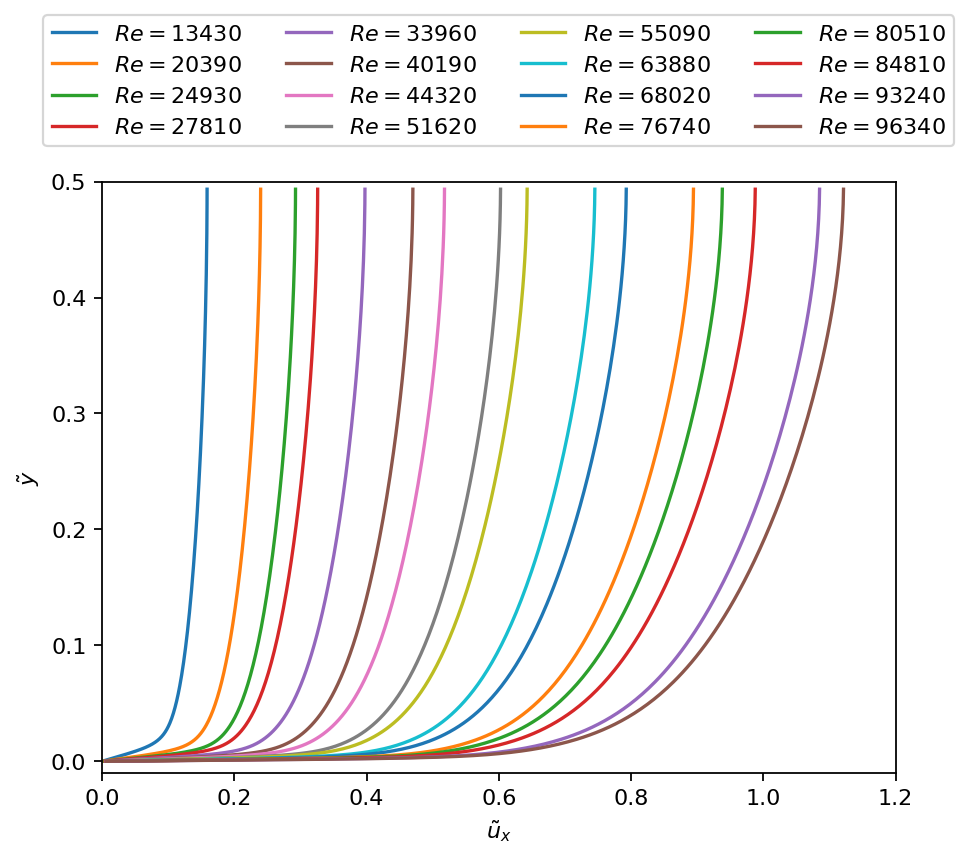

In [4]:
for i in range(len(Re)):
    plt.plot(u_x[:, i]/Ubar.max(), y/(2*delta), label=r"$Re={:1.0f}$".format(round(Re[i].item(), 0)))
plt.xlabel(r"$\tilde{u}_x$")
plt.ylabel(r"$\tilde{y}$")
plt.xlim(0.0, 1.2)
plt.ylim(-0.01, 0.5)
plt.legend(loc="upper center", ncol=4, bbox_to_anchor=[0.5, 1.3])
plt.savefig(f"{output}/developed_1d_profile_normalized.svg", bbox_inches="tight")

A first inspection of the data shows the expected behavior. As the Reynolds number increases, the average channel velocity increases and the profiles become steeper close to the wall. These observations are a good first sanity check. However, we should validate the data against known results for the same or similar settings. Luckily, the problem is relatively simple such that we can compare the outcome against an existing analytical function. We know that close to the wall, the velocity profile should follow first a linear and then a logarithmic trend. This relation is know as [law of the wall](https://en.wikipedia.org/wiki/Law_of_the_wall). Spalding's function comines both linear and logarithmic zones. However, Spalding's function is given in so-called inner coordinates:
$$
  u_\tau = \sqrt{\nu\partial_yu_x|_{y=0}/\rho},\quad y^+ = yu_\tau/\nu,\quad u^+ = u_x/u_\tau.
$$
The velocity $u_\tau$ is also called shear stress or friction velocity. Since the simulation is incompressible, we assume a density of unity. Spalding's function is then given as:
$$
  y^+ = u^+ + \left[e^{u^+\kappa} - 1 - u^+\kappa\left(1+u^+\kappa/2\right) - \left(u^+\kappa\right)^3/6\right] / E,
$$
where the constants have values of $E=9.8$ and $\kappa = 0.41$.

To compare against Spalding's function, we have to convert the velocity profiles into inner coordinates. The velocity's slope at the wall $\partial_yu_x|_{y=0}$ can be approximated for each velocity profile using finite differences and assuming a velocity of zero at the wall. The linear approximation of the slope is reasonable since the boundary layer is fully resolved by the mesh. In the figure below, we can observe how the simulation data nicely collapse almost into a single profile, which is in agreement with Spalding's function.

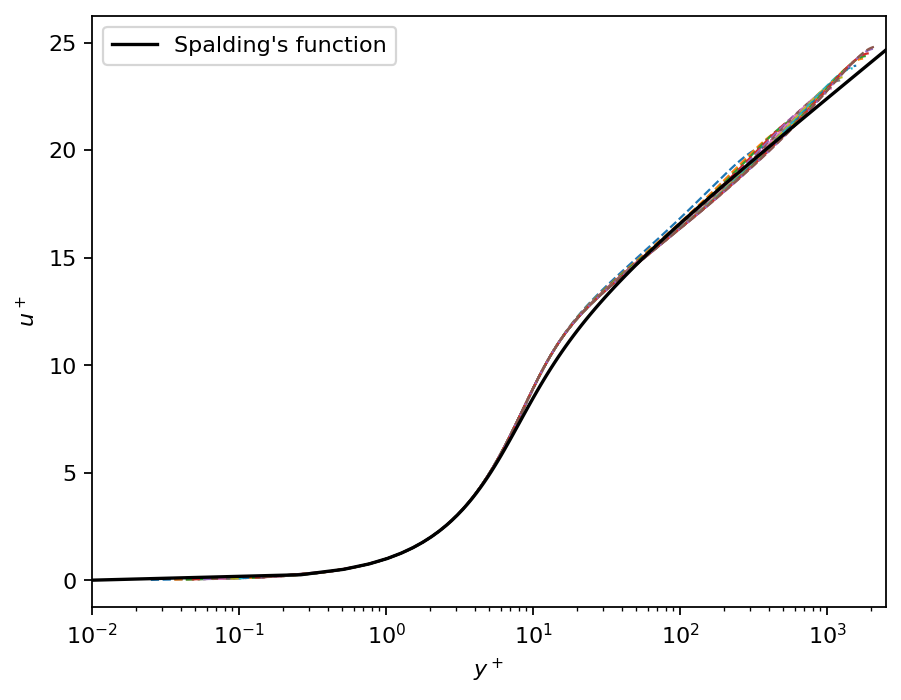

In [5]:
def spalding(up: pt.Tensor, E: float=9.8, kappa: float=0.41) -> pt.Tensor:
    """Compute Spalding's velocity profile.

    :param up: velocity in inner coordinates U-plus
    :type up: pt.Tensor
    :param E: wall roughness constant, defaults to 9.8
    :type E: float, optional
    :param kappa: van Kármán constant, defaults to 0.41
    :type kappa: float, optional
    :return: distance in inner coordinates y-plus
    :rtype: pt.Tensor
    """
    upk = up*kappa
    temp = pt.exp(upk) - 1 - upk*(1+upk/2) - upk**3/6
    return up + temp/E

dy_u_x = (0.0 - u_x[0, :]) / (0.0 - y[0])
U_tau = pt.sqrt(nu * dy_u_x)

for i, Ub in enumerate(Ubar):
    y_plus = y*U_tau[i]/nu
    U_plus = u_x[:, i] / U_tau[i]
    plt.plot(y_plus, U_plus, lw=1, ls="--")

U_spalding = pt.linspace(0.01, 25, 100)
plt.plot(spalding(U_spalding), U_spalding, c="k", label="Spalding's function")
plt.xlabel(r"$y^+$")
plt.ylabel(r"$u^+$")
plt.xlim(0.01, 2500)
plt.xscale("log")
plt.legend()
plt.savefig(f"{output}/1d_profile_inner.svg", bbox_inches="tight")

### Simple feed-forward neural networks

Deep learning (DL) is a sub-field of ML that focuses on the design, implementation, and optimization of deep neural networks. Neural networks form a class of parametrized functions characterized by great approximation capabilities, especially if high-dimensional mappings from features to labels are required. The functional form of neural networks is inspired by the [perceptron](https://en.wikipedia.org/wiki/Perceptron), which was the first mathematical approach to explain the working of neurons (nerve cells) in the brain. The building blocks of modern neural networks still have some resemblance with the original perceptron, but many modifications have been introduced. These modifications are largely driven by empirical observations and mathematical intuition. In this lecture, we introduce the mathematical form of relatively simple feed-forward neural networks with fully connected layers and use them as a black box function approximation tool. In the next lecture, we learn more about the inner workings of neural networks.

The picture below depicts a feed-forward neural network with its typical components: input and output layers, hidden layers, neurons with activations, bias units, and connections between these components.

<img src="media/example_nn.png" style="width:600px">

In the input layer, one neuron is reserved for each possible feature $x_i$ of the feature vector $\mathbf{x} = \left[x_1, x_2, ..., x_{N_f}\right]^T$, where $N_f$ is the number of features. The network sketched above has two neurons for two input features, so $N_f = 2$. Considering the test case described in the previous section, the two input features $x_1$ and $x_2$ would be the normalized channel height and the Reynolds number, and the single output would be the normalized streamwise velocity. The connections between the input and the first hidden layer represent free parameters, also called weights. If each neuron of one layer is connected with each neuron of the consecutive layer, the layers are said to be *fully connected*. Fully connected layers are part of almost any modern neural network architecture. In every neuron $j$ of a hidden layer $l$, a weighted sum $z_j^l$ of all $N_{neu}^{l-1}$ neurons (features) of the previous layer $l-1$ is computed:
$$
  z_j^l\left(\mathbf{x}^{l-1}\right) = \sum\limits_{i=1}^{N_{neu}^{l-1}} w_{ji}^{l-1} x_i^{l-1} + b_j^{l-1}.
$$
The coefficients $w_{ij}$ of weight matrix $\mathbf{W}$ are represented by the lines connecting pairs of neurons in the sketch above. $b_j$ is the bias unit for the $j$th neuron in the next layer. In vector-matrix notation, we can write the above as:
$$
  \mathbf{z}_l = \mathbf{W}_{l-1}^T \mathbf{x}_{l-1} + \mathbf{b}_{l-1},
$$
where $\mathbf{z}_l$ and $\mathbf{b}_{l-1}$ are a vector of length $N_{neu}^{l}$, $\mathbf{x}_{l-1}$ is a vectors of length $N_{neu}^{l-1}$, and $\mathbf{W}_{l-1}$ is a matrix of shape $N_{neu}^{l-1}\times N_{neu}^l$. To increase the network's ability of approximating complex functions, the weighted input must be transformed by a non-linear function. Otherwise, the resulting approximating would remain linear with respect to the inputs regardless of the amount of added layers. Motivated by the biological roots of the approach, the non-linear transformation function $a(z)$ is commonly called activation function. Typical activation functions will be covered further down in this notebook. The weighted sum of the inputs combined with the activation function results in the inputs (features) of the next layer. Therefore, one could interpret the activation's output as new features $x_j^l$:
$$
  \mathbf{x}_l = a_l(\mathbf{z}_l) = a_l(\mathbf{W}_{l-1}^T\mathbf{x}_{l-1}+\mathbf{b}_{l-1}).
$$
The length of the new feature vector corresponds to $N_{neu}^l$. Note that the activation function gets a lower script $l$ to indicate that different activation functions may be used in different layers. All networks created and trained in this lecture employ the same activation functions in all hidden layers but may use an application-specific activation for the output layer. In a general regression task, it is likely that the last activation function is linear, i.e., an identity mapping ($a(z) = z$). Following the notation introduced above, we can express a fully-connected feed-forward neural network with two hidden layers and linear (no) activation for the output as:
$$
  f_\theta(\mathbf{x}) = \mathbf{W}_2^T a_1(\mathbf{W}_1^T a_0(\mathbf{W}_0^T\mathbf{x} + \mathbf{b}_0) + \mathbf{b}_1) + \mathbf{b}_2,
$$
where $\theta$ represents all the networks tunable parameters contained in the weight matrices and bias units. The re-combination of the feature vector in each one of the network's layers may be written as a repeated function composition $f(g(x)) = f\circ g(x)$. Abbreviating the transformation in a single layer $l$ as $m_l(\mathbf{x}_l)$, the full network $f_{\theta}(\mathbf{x})$ may be expressed as:
$$
  f_{\theta}(\mathbf{x}) = m_{N_L} \circ m_{N_{L-1}}\circ ... \circ m_0 (\mathbf{x}),
$$
where $\mathbf{x}$ is the original feature vector provided by the input layer and $N_L$ is the overall number of layers. Evaluating the model for a concrete feature vector $\mathbf{x}_i$, a so-called *forward pass*, yields a prediction, typically denoted by $\hat{\mathbf{y}}_i$:
$$
  \hat{\mathbf{y}}_i = f_{\theta}(\mathbf{x}_i).
$$
Training a neural networks means optimizing its free parameters such that all predictions $\hat{\mathbf{y}}_i$ match the true labels $\mathbf{y}_i$ closely. The precise formulation and implementation of the optimization problem follows in the next sections.

The define the network structure discussed before, we can employ [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) modules, [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) activations, and wrap the layers in a [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html?highlight=sequential#torch.nn.Sequential) container, which forwards the output from one layer to the next. Making predictions works by calling the sequential container like a function.

In [6]:
n_in, n_out = 2, 1
n_neurons = 20
simple_network = pt.nn.Sequential(
    pt.nn.Linear(n_in, n_neurons),
    pt.nn.ReLU(),
    pt.nn.Linear(n_neurons, n_neurons),
    pt.nn.ReLU(),
    pt.nn.Linear(n_neurons, n_out)
)
example_input = pt.rand(n_in)
simple_network(example_input)

tensor([-0.0420], grad_fn=<AddBackward0>)

### Preparing the datasets

PyTorch comes with several functions and classes that facilitate the creation of datasets. These abstractions are bundled the the subpackage `torch.utils.data`. As a first step, we reshape our data and wrap the features and labels in a [TensorDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset). `TensorDatasets` are special in that the entire data must fit into memory. Keeping the data in memory avoids the relatively slow loading from the hard disk. On the other hand, the size of the dataset is limited by the available memory. For larger datasets, PyTorch provides a general [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class, which prefetches data from disk to reduce waiting times during training.

The `TensorDataset` constructor expects feature and label tensors as input. Currently, we have the distance normal to the wall, the Reynolds numbers, and the velocity profiles in separate data structures. However, the data structure needed to train a model $\tilde{u}_x = f_\theta(\tilde{y}, Re)$ looks as follows:

| $\tilde{u}_x$ | $\tilde{y}$ | $Re$ |
|:-----:|:---:|:----:|
| $0.131$ | $0.0001$ | $98362$ |
| $0.201$ | $0.0002$ | $98362$ |
| ... | ... | ... |

The order of the columns is arbitrary and we could also separate the label $\tilde{u}_x$ from the two features $\tilde{y}$ and $Re$. For $N_r$ selected Reynolds numbers/profiles and $N_y$ points per profile, the resulting tensor should have $N_r\times N_y$ rows and three columns. The `reshape_data` function below creates the required format.

In [8]:
def reshape_data(u_x_norm: pt.Tensor, y_norm: pt.Tensor, Re: pt.Tensor) -> pt.Tensor:
    """Create feature and label vectors.

    :param u_x_norm: velocity profiles normalized with Ubar; first zeroth dimension
     corresponds to the distance y; first dimension corresponds to the Reynolds number
    :type u_x_norm: pt.Tensor
    :param y_norm: distance from the wall normalized by twice the channel hight;
        ordered from lowest to largest
    :type y_norm: pt.Tensor
    :param Re: Reynolds number based on average velocity, twice the channel height,
        and kinematic viscosity
    :type Re: pt.Tensor
    :return: data suitable for training; if there are Ny points normal to
        the wall and Nr different Reynolds numbers, the resulting tensor
        has the shape (Ny*Nr, 3)
    :rtype: pt.Tensor
    """
    data = pt.zeros((u_x_norm.shape[0]*u_x_norm.shape[1], 3))
    for i in range(u_x_norm.shape[1]):
        start, end = i*u_x_norm.shape[0], (i+1)*u_x_norm.shape[0]
        data[start:end, 0] = u_x_norm[:, i]
        data[start:end, 1] = y_norm
        data[start:end, 2] = Re[i]
    return data

In [9]:
# normalize velocity and wall normal distance
u_x_norm = u_x / Ubar.max()
y_norm = y/(2*delta)
# reshape data
reshaped_data = reshape_data(u_x_norm, y_norm, Re)
# create a TensorDataset
dataset = pt.utils.data.TensorDataset(reshaped_data[:, 1:], reshaped_data[:, 0])
# the dataset supports indexing; dataset[0] returns the 0th feature-label-pair
dataset[0]

(tensor([3.3002e-05, 1.3430e+04]), tensor(0.0002))

Next, we split the data into three parts. One part contains most of the data and will be used for optimizing the network's free parameters. The other two parts are significantly smaller and will be used to evaluate the training process. One of the smaller parts is meant to provide feedback during the optimization while the other one is only evaluated after the training is done. In summary, the data is split into:

- **training data**: optimization of model parameters
- **validation data**: model evaluation during training
- **testing data**: final model evaluation after training

Note that the naming of testing and validation data is somewhat arbitrary and ML practitioners may use the terms interchangeably. For the low-dimensional problem considered here, we can inspect the model's properties by means of standard visualization techniques. However, as the problems become high-dimensional, the split is essential to assess the model's characteristics. More about the assessment follows in a dedicated section of this notebook.

PyTorch's [random_split](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split) divides a dataset according to user-defined sizes. The code below creates three datasets, where the first dataset contains roughly $70\%$ of the data and the remaining features-label-pairs are equally distributed in validation and testing data.

In [10]:
train_size = int(0.7*len(dataset))
val_size = int(0.15*len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = pt.utils.data.random_split(dataset, (train_size, val_size, test_size))
len(dataset), len(train_dataset), len(val_dataset), len(test_dataset)

(3200, 2240, 480, 480)

The splitting approach employed before is a good option for general datasets. However, our data comes with a certain structure related to the fact that groups of feature-labels-pairs belong to a single profile/simulation. With the current split, validation and testing data won't be very different from the training data due the high mesh resolution in $y$ direction. What we rather want to test with the additional two datasets in the performance at unknown Reynolds numbers. We can build this stricter evaluation approach by splitting the datasets based on individual velocity profiles. The randomly select the profiles/simulations, we use the [multinomial](https://pytorch.org/docs/stable/generated/torch.multinomial.html) probability distribution. The multinomial probability distribution draws samples from discrete events (categories) according to a given list of probabilities for each category. When sampling, the probability distribution returns the indices of the drawn categories. In our case, there are 16 different categories, one for each Reynolds number. The probability tensor is initialized with ones, meaning that every category has the same chance of being drawn. We then draw ten Reynolds numbers for training, set the corresponding indices of the probability tensor to zero, and repeat the process for validation and testing data. It is important to note that, by the implementation's defaults, no category will be drawn twice because the `replacement` variable is set to `False`.

A final constrained we apply to the splitting strategy concerns the minimum and maximum Reynolds numbers. We don't want the model to extrapolate, which is in general something to avoid. Therefore, we enforce the lowest and highest $Re$ data to be in the training set. This task is easy since the `Re` tensor is already sorted.

In [11]:
Re

tensor([13429.9990, 20390.0000, 24930.0000, 27810.0020, 33960.0000, 40190.0000,
        44320.0000, 51620.0000, 55090.0000, 63880.0039, 68020.0000, 76740.0000,
        80510.0000, 84810.0000, 93240.0000, 96340.0000])

In [12]:
# select two snapshots for testing
n_Re = len(Re)
probs = pt.ones(u_x.shape[-1])
probs[0] = 0.0
probs[-1] = 0.0
train_size, val_size, test_size = 8, 3, 3
test_idx = pt.multinomial(probs, test_size)
probs[test_idx] = 0.0
val_idx = pt.multinomial(probs, val_size)
probs[val_idx] = 0.0
train_idx = pt.multinomial(probs, train_size)
train_idx = pt.cat((train_idx, pt.tensor([0, n_Re-1], dtype=pt.int64)))
print("Re for testing: ", Re[test_idx])
print("Re for validation: ", Re[val_idx])
print("Re for training: ", Re[train_idx])

Re for testing:  tensor([80510., 40190., 20390.])
Re for validation:  tensor([63880.0039, 51620.0000, 76740.0000])
Re for training:  tensor([93240.0000, 55090.0000, 27810.0020, 24930.0000, 33960.0000, 68020.0000,
        84810.0000, 44320.0000, 13429.9990, 96340.0000])


Before creating the final datasets, we need to normalize the data to avoid roundoff errors. The `MinMaxScaler` class defined below wraps around the minimum/maximum values and scaling/rescaling functions. We also created a dataset without normalization to show the importance of feature normalization later on. Note that we create the scaler objects only based on the training data, because we don't want to use any information from the test data during training.

In [13]:
class MinMaxScaler(object):
    """Class to scale/re-scale data to the range [-1, 1] and back.
    """
    def __init__(self):
        self.min = None
        self.max = None
        self.initialized = False

    def fit(self, data):
        self.min = data.min(dim=0).values
        self.max = data.max(dim=0).values
        self.initialized = True
        return self

    def scale(self, data):
        assert self.initialized
        data_norm = (data - self.min) / (self.max - self.min)
        return 2.0*data_norm - 1.0

    def rescale(self, data_norm):
        assert self.initialized
        data = (data_norm + 1.0) * 0.5
        return data * (self.max - self.min) + self.min

In [14]:
train_tensor = reshape_data(u_x_norm[:, train_idx], y_norm, Re[train_idx])
val_tensor = reshape_data(u_x_norm[:, val_idx], y_norm, Re[val_idx])
test_tensor = reshape_data(u_x_norm[:, test_idx], y_norm, Re[test_idx])
feature_scaler = MinMaxScaler().fit(train_tensor[:, 1:])
label_scaler = MinMaxScaler().fit(train_tensor[:, 0])
train_dataset = pt.utils.data.TensorDataset(
    feature_scaler.scale(train_tensor[:, 1:]), label_scaler.scale(train_tensor[:, 0]).unsqueeze(-1)
)
val_dataset = pt.utils.data.TensorDataset(
    feature_scaler.scale(val_tensor[:, 1:]), label_scaler.scale(val_tensor[:, 0]).unsqueeze(-1)
)
test_dataset = pt.utils.data.TensorDataset(
    feature_scaler.scale(test_tensor[:, 1:]), label_scaler.scale(test_tensor[:, 0]).unsqueeze(-1)
)
train_dataset_raw = pt.utils.data.TensorDataset(train_tensor[:, 1:], train_tensor[:, 0].unsqueeze(-1))
val_dataset_raw = pt.utils.data.TensorDataset(val_tensor[:, 1:], val_tensor[:, 0].unsqueeze(-1))
test_dataset_raw = pt.utils.data.TensorDataset(test_tensor[:, 1:], test_tensor[:, 0].unsqueeze(-1))
len(train_dataset), len(val_dataset), len(test_dataset)

(2000, 600, 600)

There is one final useful abstraction for datasets, namely a [Dataloader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). As you will see in the next section, it is useful loop over the datasets in small junks of feature-label-pairs, so-called batches. The dataloader takes a dataset as input and allows us to loop over such non-overlapping batches (non-overlapping means that a single feature-label-pair cannot be contained in multiple batches). Moreover, we can let the dataloader shuffle the batches such that the batches are different each time we loop over the dataset (we don't want the order of the data in the set to affect the training).

In [15]:
train_loader = pt.utils.data.DataLoader(train_dataset, batch_size=int(len(train_dataset) / 4), shuffle=True)
for features, labels in train_loader:
    print(features.shape, labels.shape)

torch.Size([500, 2]) torch.Size([500, 1])
torch.Size([500, 2]) torch.Size([500, 1])
torch.Size([500, 2]) torch.Size([500, 1])
torch.Size([500, 2]) torch.Size([500, 1])


### Generic training loop

To simplify notation, we define a long vector $\mathbf{\theta}$ holding all of the network's parameters (weights). For optimizing the wights, we need a metric expressing how good the model's prediction is. The most common metric used for regression problems is the mean squared error (MSE), also referred to as $L_2$ norm/loss. For a set of $N$ generic pairs of feature vectors $\mathbf{x}_i$ and label vectors $\mathbf{y}_i$, the $L_2$ loss is defined as:
$$
  L_2(\mathbf{\mathbf{\theta}}) = \frac{1}{N}\sum\limits_{i=1}^N \left( \mathbf{y}_i - f_{\mathbf{\theta}}(\mathbf{x}_i) \right)^2,
$$
where $f_{\mathbf{\theta}}(\mathbf{x})$ is the model with weights $\mathbf{\theta}$ and $ \hat{\mathbf{y}}_i = f_{\mathbf{\theta}}(\mathbf{x}_i) $ is the prediction for the $i$th feature vector instance. The goal of the parameter optimization/training is to find the parameter configuration $\mathbf{\theta}^\ast$ yielding the minimal loss:
$$
  \mathbf{\theta}^\ast = \underset{\mathbf{\theta}}{\mathrm{argmin}} L_2 (\mathbf{\theta}).
$$

The most common update rule for the model weights is called gradient decent. The idea is simple: we compute the gradient of the loss function with respect to the weights and make a small adjustment of the weights in the negative gradient direction:
$$
  \mathbf{\theta}_{n+1} = \mathbf{\theta}_n - \lambda_0 \frac{\mathrm{d}L}{\mathrm{d}\mathbf{\theta}},
$$
where $n$ indicate the current iteration, $\lambda_0$ is the learning rate, and $L$ represents a generic loss function. Modern training approaches use a more advanced version of gradient decent that may be expressed as:
$$
  \mathbf{\theta}_{n+1} = \mathbf{\theta}_n - g\left(\lambda_0,\frac{\mathrm{d}L}{\mathrm{d}\mathbf{\theta}}\right),
$$
where $g$ is a functional abstraction of techniques like momentum, learning rate scheduling, and gradient clipping. The first two of these techniques are introduced and implemented later on in this notebook.

In general, the loss function of a neural network may be non-linear and non-convex. Therefore, the loss values do not always decreases monotonically. If we perform a fixed number of optimization epochs/iterations, the final parameter configuration is not necessarily the best one. A simple strategy to keep the best model is to compare the current loss value against the best loss values encountered during the training. If a new best loss is reached, a snapshot of the model is saved. After the training, we can load and evaluate only the best model.

The code block below implements a relatively comprehensive training loop, which will be used for almost all examples in the course involving neural networks. A few important features of the `train_model` function are:

- evaluation of user-defined metric on training, validation, and test data
- monitoring of training performance in terms of loss and training time
- saving of checkpoints; the checkpoints allow to restart the training, e.g., after an unexpected failure
- saving of the best model based on the training or validation loss
- learning rate adjustment based on a user-defined scheduler

Only some of these features are explored in this notebook.

In [16]:
def run_epoch(
    model: pt.nn.Module,
    optimizer: pt.optim.Optimizer,
    data_loader: pt.utils.data.DataLoader,
    loss_func: pt.nn.Module,
    device: str,
    results: dict,
    score_funcs: dict,
    prefix: str
    ) -> float:
    """Perform one optimizing step on a model.

    This loop is a slightly modified version of 'run_epoch'
    provided in chapter 5 of 'Inside Deep Learning' by Edward Raff;
    refer to:
    https://github.com/EdwardRaff/Inside-Deep-Learning/blob/main/idlmam.py
    """

    # keeping track of loss, predictions, and time
    running_loss, labels_true, labels_pred = [], [], []
    start_time = time()

    # loop over all batches
    for features, labels in data_loader:
        features, labels = features.to(device), labels.to(device)
        pred = model(features)
        loss = loss_func(labels, pred)
        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        running_loss.append(loss.item())

        # the dataset might get shuffled in the next loop
        if len(score_funcs) > 0:
            labels_true.extend(labels.detach().cpu().tolist())
            labels_pred.extend(pred.detach().cpu().tolist())

    # keep track of performance
    results[f"{prefix}_loss"].append(sum(running_loss) / len(running_loss))
    for name, func in score_funcs.items():
        results[f"{prefix}_{name}"].append(func(labels_true, labels_pred))

    return time() - start_time


def train_model(
    model: pt.nn.Module,
    loss_func: pt.nn.Module,
    train_loader: pt.utils.data.DataLoader,
    val_loader: pt.utils.data.DataLoader = None,
    test_loader: pt.utils.data.DataLoader = None,
    score_funcs: dict = {},
    epochs: int = 100,
    device: str = "cpu",
    checkpoint_file: str = None,
    log_all: bool = False,
    lr_schedule: pt.optim.lr_scheduler._LRScheduler = None,
    optimizer: pt.optim.Optimizer = None) -> pd.DataFrame:
    """Perform one optimizing step on a model.

    This function is a slightly modified version of 'train_network'
    provided in chapter 5 of 'Inside Deep Learning' by Edward Raff;
    refer to:
    https://github.com/EdwardRaff/Inside-Deep-Learning/blob/main/idlmam.py
    """

    # dictionary for keeping track of training performance
    results = defaultdict(list)
    best_loss = float("inf")
    ref_loss = "train_loss" if val_loader is None else "val_loss"

    # use AdamW as default optimizer if none specified
    delete_optimizer = False
    if optimizer is None:
        optimizer = pt.optim.AdamW(model.parameters())
        delete_optimizer = True

    total_train_time = 0.0
    model.to(device)
    for e in range(epochs):
        # model update
        model = model.train()
        total_train_time += run_epoch(
            model, optimizer, train_loader, loss_func, device,
            results, score_funcs, prefix="train"
        )
        results["epoch"].append(e)
        results["total_time"].append(total_train_time)
        message = f"Training loss: {results['train_loss'][-1]:2.6e}"


        # validation dataset
        if val_loader is not None:
            model = model.eval()
            with pt.no_grad():
                _ = run_epoch(
                    model, optimizer, val_loader, loss_func, device,
                    results, score_funcs, prefix="val"
                )
            message += f"; Validation loss: {results['val_loss'][-1]:2.6e}"

        # update of learning rate
        if lr_schedule is not None:
            if isinstance(lr_schedule, pt.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(results["val_loss"][-1])
            else:
                lr_schedule.step()

        # test dataset
        if test_loader is not None:
            model = model.eval()
            with pt.no_grad():
                _ = run_epoch(
                    model, optimizer, test_loader, loss_func, device,
                    results, score_funcs, prefix="test"
                )
            message += f"; Test loss: {results['test_loss'][-1]:2.6e}"

        # save checkpoint
        if checkpoint_file is not None:
            suffix = f"_epoch_{e}" if log_all else ""
            pt.save(
                {
                    "epoch" : e,
                    "model_state_dict" : model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "results" : results
                }, checkpoint_file + suffix
            )
            latest_loss = results[ref_loss][-1]
            if latest_loss < best_loss:
                best_loss = latest_loss
                copy(checkpoint_file + suffix, checkpoint_file + "_best")
                

        print(
            "\r", f"Epoch {e:4d}/{epochs - 1} - " + message, end=""
        )

    # if the optimizer was created in the training loop,
    # delete if to avoid unwanted side effects
    if delete_optimizer:
        del optimizer

    return pd.DataFrame.from_dict(results)

The function below simplifies the construction of simple fully-connected neural networks with a variable of hidden layers.

In [17]:
def create_simple_network(n_in: int, n_out: int, n_neurons: int,
    n_hidden: int, activation: pt.nn.Module) -> pt.nn.Sequential:
    layers = [
        pt.nn.Linear(n_in, n_neurons),
        activation()
    ]
    for _ in range(n_hidden):
        layers.append(pt.nn.Linear(n_neurons, n_neurons))
        layers.append(activation())
    layers.append(pt.nn.Linear(n_neurons, n_out))
    return pt.nn.Sequential(*layers)

In [101]:
model_0_base = create_simple_network(2, 1, 50, 2, pt.nn.ReLU)
train_loader = pt.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
val_loader = pt.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset))
test_loader = pt.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))
score_funcs = {
    "Lmax" : metrics.max_error,
    "L1" : metrics.mean_absolute_error,
    "R2" : metrics.r2_score
}

In [102]:
model_0 = deepcopy(model_0_base)
results_0 = train_model(
    model_0,
    pt.nn.MSELoss(),
    train_loader, val_loader, test_loader,
    score_funcs,
    500,
    optimizer=pt.optim.AdamW(model_0.parameters(), lr=0.001)
)

 Epoch  499/499 - Training loss: 3.703182e-03; Validation loss: 3.137902e-03; Test loss: 2.313281e-03

Plotting the MSE loss indicates a steady learning. With more epochs, the loss is likely to drop further. Moreover, the loss computed on validation and test data shows a similar trend as on the training data. Therefore, the model is most likely not overfitting (memorizing) the training data.

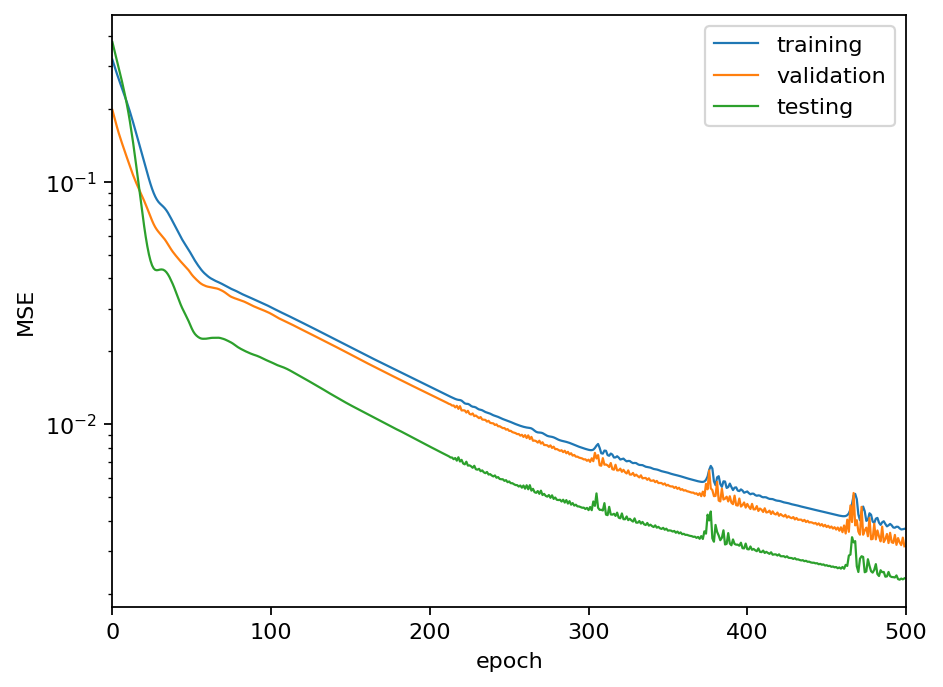

In [103]:
plt.plot(results_0["epoch"], results_0["train_loss"], lw=1, label="training")
plt.plot(results_0["epoch"], results_0["val_loss"], lw=1, label="validation")
plt.plot(results_0["epoch"], results_0["test_loss"], lw=1, label="testing")
plt.yscale("log")
plt.xlim(0, 500)
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.legend()
plt.savefig(join(output, "loss_lecture_4_model_0.svg"), bbox_inches="tight")
plt.show()

Normalizing the data is enormously important to mitigate the influence of roundoff errors. To demonstrate the impact of normalization, we repeat the training with the unscaled data. The enormous difference in the order of magnitude between $\tilde{y}$ and $Re$ inhibits the learning after about 150 epochs.

In [104]:
train_loader_raw = pt.utils.data.DataLoader(train_dataset_raw, batch_size=len(train_dataset_raw), shuffle=True)
val_loader_raw = pt.utils.data.DataLoader(val_dataset_raw, batch_size=len(val_dataset_raw))
test_loader_raw = pt.utils.data.DataLoader(test_dataset_raw, batch_size=len(test_dataset_raw))
model_0_raw = deepcopy(model_0_base)
results_0_raw = train_model(
    model_0_raw,
    pt.nn.MSELoss(),
    train_loader_raw, val_loader_raw, test_loader_raw,
    epochs=500,
    optimizer=pt.optim.AdamW(model_0_raw.parameters(), lr=0.001)
)

 Epoch  499/499 - Training loss: 3.648483e-02; Validation loss: 3.476597e-02; Test loss: 2.301314e-02

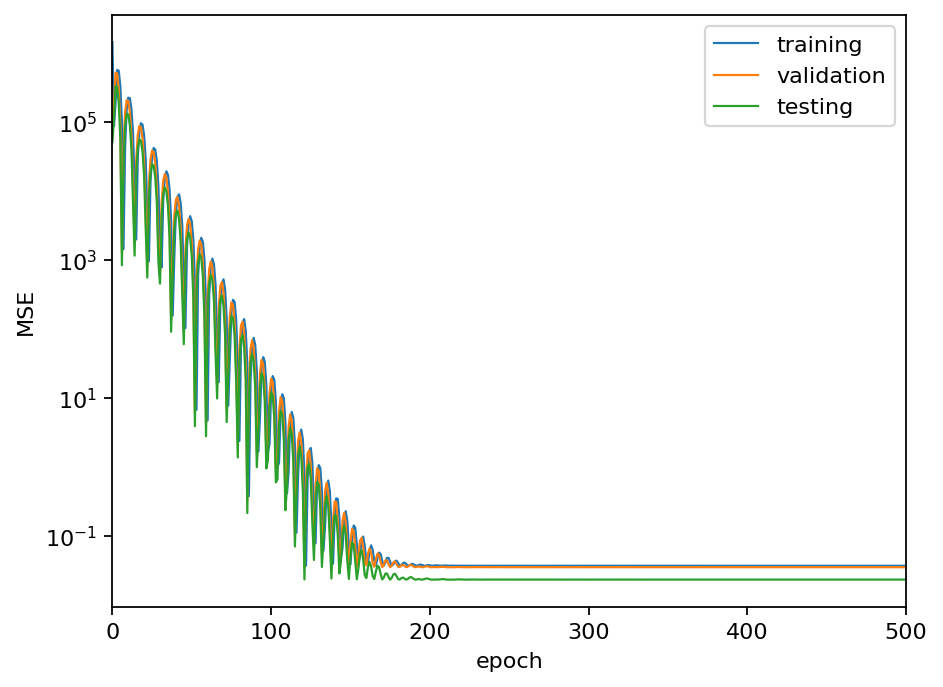

In [105]:
plt.plot(results_0_raw["epoch"], results_0_raw["train_loss"], lw=1, label="training")
plt.plot(results_0_raw["epoch"], results_0_raw["val_loss"], lw=1, label="validation")
plt.plot(results_0_raw["epoch"], results_0_raw["test_loss"], lw=1, label="testing")
plt.yscale("log")
plt.xlim(0, 500)
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.legend()
plt.savefig(join(output, "loss_lecture_4_model_0_raw.svg"), bbox_inches="tight")
plt.show()

Comparing the prediction of the first model against the true labels shows that the model reflect the trend of with respect to the Reynolds number already quite well. Some fluctuations of the predicted profiles around the true ones are visible.

In [106]:
def make_prediction(model, data, feature_scaler, label_scaler):
    return label_scaler.rescale(
        model(feature_scaler.scale(data)).squeeze().detach()
    )

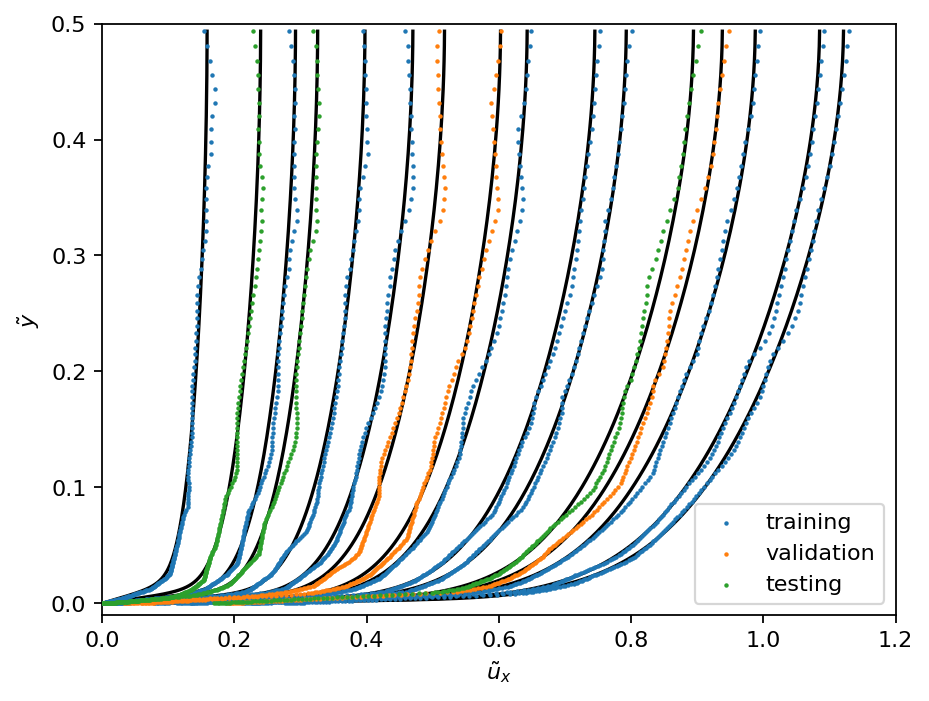

In [107]:
pred_train_0 = make_prediction(model_0, train_tensor[:, 1:], feature_scaler, label_scaler)
pred_val_0 = make_prediction(model_0, val_tensor[:, 1:], feature_scaler, label_scaler)
pred_test_0 = make_prediction(model_0, test_tensor[:, 1:], feature_scaler, label_scaler)


n_points = len(y)
for i in range(len(Re)):
    plt.plot(u_x[:, i]/Ubar.max(), y/(2*delta), ls="-", c="k")
plt.scatter(pred_train_0, train_tensor[:, 1], s=1, c="C0", zorder=6, label="training")
plt.scatter(pred_val_0, val_tensor[:, 1], s=1, c="C1", zorder=6, label="validation")
plt.scatter(pred_test_0, test_tensor[:, 1], s=1, c="C2", zorder=6, label="testing")
plt.xlabel(r"$\tilde{u}_x$")
plt.ylabel(r"$\tilde{y}$")
plt.xlim(0, 1.2)
plt.ylim(-0.01, 0.5)
plt.legend()
plt.savefig(join(output, "prediction_lecture_4_model_0.svg"), bbox_inches="tight")
plt.show()

### Training with batches of data

So far, we used the entire training dataset at once to update the weights in a single epoch. Instead, we can also create small junks of data and update the weights based on each individual junk. This idea is called batch training and leads many more updates within a single epoch. Moreover, computing the gradient based on a subset of the data sometimes helps to overcome local minima and reduces the memory requirements of the training. A drawback of decreasing the batch size, i.e., creating smaller junks, is the increased training time because smaller batches don't allow to exploit parallelization to its full potential.

In [108]:
batch_sizes = (64, 128, 512, len(train_dataset))
batch_results = []
for bs in batch_sizes:
    model_bs = deepcopy(model_0_base)
    batch_results.append(
        train_model(
            model_bs,
            pt.nn.MSELoss(),
            pt.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True),
            epochs=500,
            optimizer=pt.optim.AdamW(model_bs.parameters(), lr=0.001)
        )
    )

 Epoch  499/499 - Training loss: 3.650685e-03

In the plot below we see that the loss drops significantly faster for smaller batches and reaches also lower final loss values. However, also the loss fluctuations increase as the gradient prediction becomes more spurious.

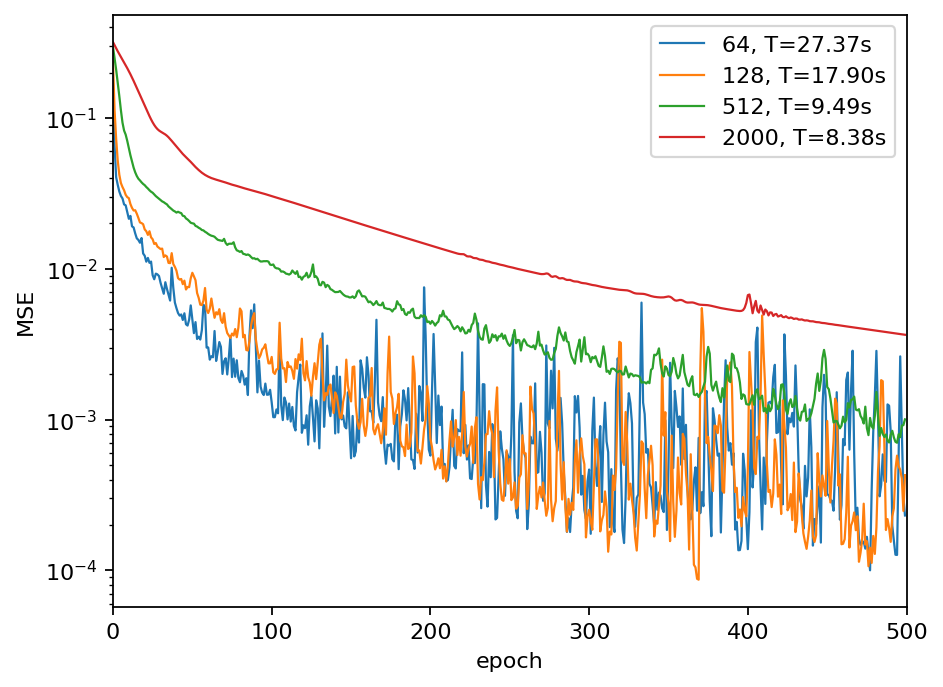

In [109]:
for bs, res in zip(batch_sizes, batch_results):
    plt.plot(res["epoch"], res["train_loss"], lw=1, label=f"{bs:d}, T={res['total_time'].values[-1]:2.2f}s")

plt.xlabel("epoch")
plt.ylabel("MSE")
plt.yscale("log")
plt.xlim(0, 500)
plt.legend()
plt.savefig(join(output, "batch_size_lecture_4.svg"), bbox_inches="tight")
plt.show()

### Learning rate adjustment

One way to counteract oscillations in the training loss is an adjustment of the learning rate. Smaller learning lead to smaller changes in the weights. However, if the learning rate is too small, we may never reach a good optimum or require an excessive amount of epochs/resources. In the learning rate test below, a value of $\lambda_0 = 5\times 10^{-4}$ yields the best final loss value. Nonetheless, higher learning rates yield a much stronger drop in the initial epochs. Next, we combine the best attributes of low and high learning rates by employing dynamic learning rate adjustment.

In [110]:
lr_to_test = [1.0e-2, 5.0e-3, 1.0e-3, 5.0e-4, 1.0e-4]
lr_results = []
train_loader = pt.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
for lr in lr_to_test:
    model_lr = deepcopy(model_0_base)
    lr_results.append(
        train_model(
            model_lr,
            pt.nn.MSELoss(),
            train_loader, val_loader, test_loader,
            epochs=500,
            optimizer=pt.optim.AdamW(model_lr.parameters(), lr=lr)
        )
    )

 Epoch  499/499 - Training loss: 2.593159e-03; Validation loss: 2.350085e-03; Test loss: 2.139329e-03

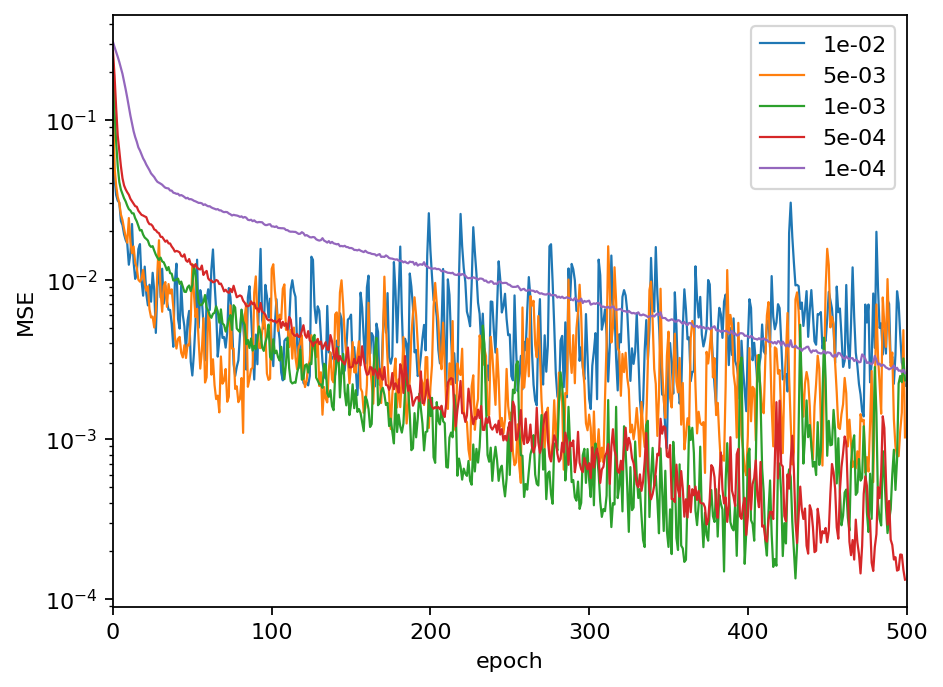

In [111]:
for lr, res in zip(lr_to_test, lr_results):
    plt.plot(res["epoch"], res["train_loss"], lw=1, label=f"{lr:1.0e}")

plt.xlabel("epoch")
plt.ylabel("MSE")
plt.yscale("log")
plt.xlim(0, 500)
plt.legend()
plt.savefig(join(output, "lr_bs128_lecture_4.svg"), bbox_inches="tight")
plt.show()

In the cells below, several scheduling strategies for the learning rate are compared:
- **const.**: constant learning rate as initialized in the optimizer
- **exp. decay:** exponential decay from the initial to the minimum value within a given number of epochs
- **step decay:** learning rate reduction every $S$ steps
- **cosine:** oscillatory adjustment of the learning rate around the initial value; might help to overcome local minima
- **plateau:** reduce learning rate by a given factor whenever the validation loss did not decrease for `patience` steps

The stepwise, exponential, and plateau reduction yield improved final loss value, accelerate the learning, and mitigate loss fluctuations towards the end of the training.

In [112]:
model_exp_decay = deepcopy(model_0_base)
train_loader = pt.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
optimizer = optimizer=pt.optim.AdamW(model_exp_decay.parameters(), lr=0.01)
gamma_exp = (1.0e-4 / 1.0e-2)**(1.0/500)
scheduler = pt.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma_exp)

results_exp_decay = train_model(
    model_exp_decay,
    pt.nn.MSELoss(),
    train_loader, val_loader, test_loader,
    epochs=500,
    lr_schedule=scheduler,
    optimizer=optimizer
)

 Epoch  499/499 - Training loss: 3.927640e-05; Validation loss: 1.669829e-04; Test loss: 1.406699e-04

In [113]:
model_step_decay = deepcopy(model_0_base)
optimizer = optimizer=pt.optim.AdamW(model_step_decay.parameters(), lr=0.01)
gamma_step = 0.3
scheduler = pt.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=500//4, gamma=gamma_step)

results_step_decay = train_model(
    model_step_decay,
    pt.nn.MSELoss(),
    train_loader, val_loader, test_loader,
    epochs=500,
    lr_schedule=scheduler,
    optimizer=optimizer
)

 Epoch  499/499 - Training loss: 2.291339e-04; Validation loss: 5.352701e-04; Test loss: 5.303427e-04

In [114]:
model_cosine = deepcopy(model_0_base)
optimizer = optimizer=pt.optim.AdamW(model_cosine.parameters(), lr=0.001)
scheduler = pt.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=500//3, eta_min=1.0e-4)

results_cosine = train_model(
    model_cosine,
    pt.nn.MSELoss(),
    train_loader, val_loader, test_loader,
    epochs=500,
    lr_schedule=scheduler,
    optimizer=optimizer
)

 Epoch  499/499 - Training loss: 9.224808e-05; Validation loss: 5.831620e-04; Test loss: 3.860441e-04

In [115]:
model_plateau = deepcopy(model_0_base)
optimizer = optimizer=pt.optim.AdamW(model_plateau.parameters(), lr=0.01)
scheduler = pt.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", factor=0.5, patience=20, min_lr=1.0e-4)
results_plateau = train_model(
    model_plateau,
    pt.nn.MSELoss(),
    train_loader, val_loader, test_loader,
    epochs=500,
    lr_schedule=scheduler,
    optimizer=optimizer
)

 Epoch  499/499 - Training loss: 7.438762e-05; Validation loss: 5.873441e-04; Test loss: 1.206016e-04

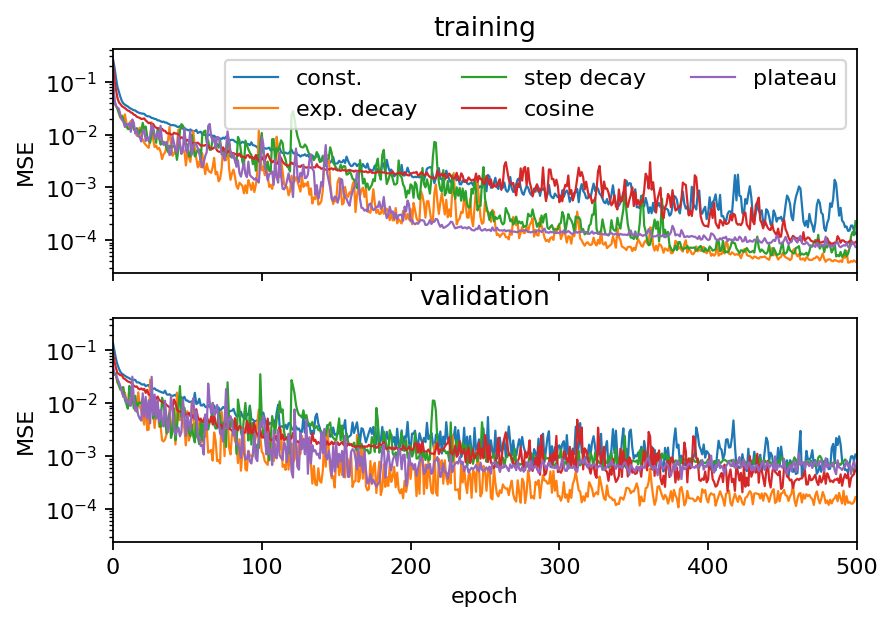

In [116]:
scheduler_res = {
    "const." : lr_results[-2],
    "exp. decay" : results_exp_decay,
    "step decay" : results_step_decay,
    "cosine" : results_cosine,
    "plateau" : results_plateau
}

fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 4), sharex=True, sharey=True)
for key, res in scheduler_res.items():
    ax1.plot(res["epoch"], res["train_loss"], lw=1, label=f"{key}")
    ax2.plot(res["epoch"], res["val_loss"], lw=1, label=f"{key}")

ax1.set_title("training")
ax2.set_title("validation")
ax2.set_xlabel("epoch")
for ax in (ax1, ax2):
    ax.set_ylabel("MSE")
    ax.set_yscale("log")
ax1.set_xlim(0, 500)
ax1.legend(ncol=3)
plt.savefig(join(output, "lr_scheduler_bs128_lecture_4.svg"), bbox_inches="tight")
plt.show()

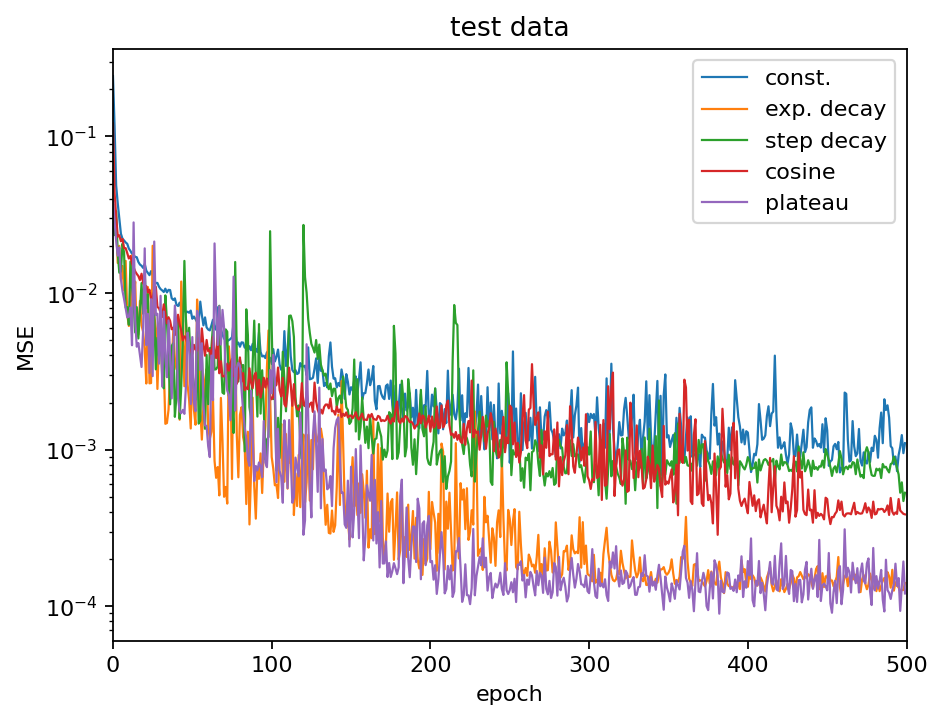

In [117]:
for i, (key, res) in enumerate(scheduler_res.items()):
    plt.plot(res["epoch"], res["test_loss"], lw=1, label=f"{key}")

plt.xlabel("epoch")
plt.ylabel("MSE")
plt.yscale("log")
plt.xlim(0, 500)
plt.legend()
plt.title("test data")
plt.savefig(join(output, "lr_scheduler_bs128_test_lecture_4.svg"), bbox_inches="tight")
plt.show()

The prediction below shows improved accuracy and reduced oscillations compared to the first attempt.

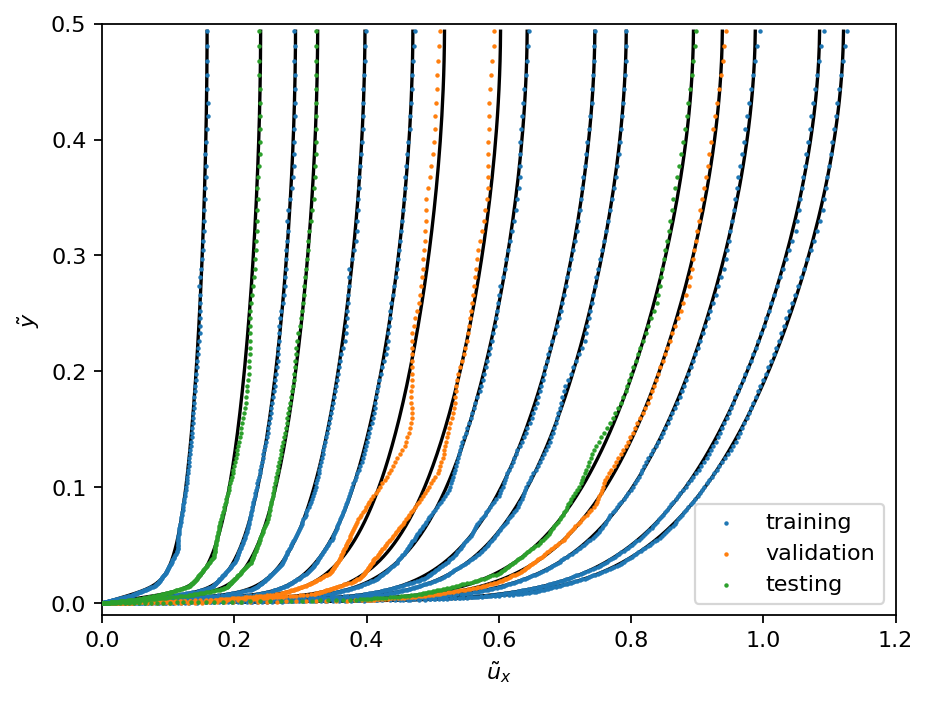

In [118]:
pred_train_pl = make_prediction(model_plateau, train_tensor[:, 1:], feature_scaler, label_scaler)
pred_val_pl = make_prediction(model_plateau, val_tensor[:, 1:], feature_scaler, label_scaler)
pred_test_pl = make_prediction(model_plateau, test_tensor[:, 1:], feature_scaler, label_scaler)


n_points = len(y)
for i in range(len(Re)):
    plt.plot(u_x[:, i]/Ubar.max(), y/(2*delta), ls="-", c="k")
plt.scatter(pred_train_pl, train_tensor[:, 1], s=1, c="C0", zorder=6, label="training")
plt.scatter(pred_val_pl, val_tensor[:, 1], s=1, c="C1", zorder=6, label="validation")
plt.scatter(pred_test_pl, test_tensor[:, 1], s=1, c="C2", zorder=6, label="testing")
plt.xlabel(r"$\tilde{u}_x$")
plt.ylabel(r"$\tilde{y}$")
plt.xlim(0.0, 1.2)
plt.ylim(-0.01, 0.5)
plt.legend()
plt.savefig(join(output, "prediction_lecture_4_model_pl.svg"), bbox_inches="tight")
plt.show()

### Activation functions

An essential element of neural networks are the activation functions applied to the weighted sum at each neuron. There are a few heuristic criteria for suitable activation function:

- nonlinear
- continuous with infinite support
- monotonic
- constant slope
- effectively computable

There is no single activation function suiting all of the above requirements at once. The activation functions of hidden layers should be always nonlinear, because otherwise, the fully connected layers could be condensed into a single layers. Only the output layer might employ an identity activation, e.g., for regression problems. For classification, there are specialized activation functions converting the input into a probability or the logarithm thereof. The most common activation functions for hidden layers are depicted below.

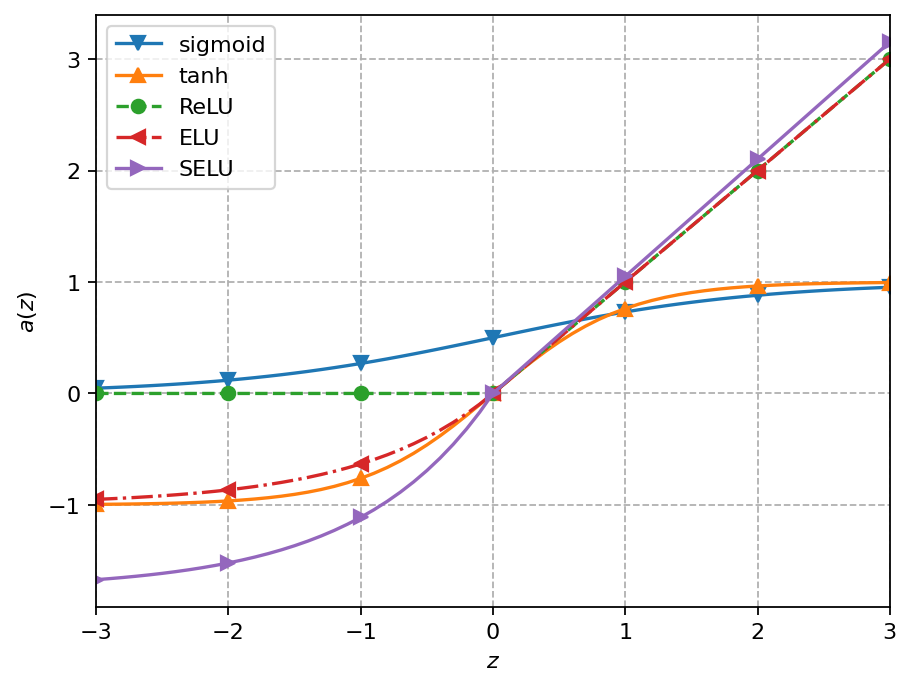

In [119]:
activations = {
    "sigmoid" : pt.nn.Sigmoid,
    "tanh" : pt.nn.Tanh,
    "ReLU" : pt.nn.ReLU,
    "ELU" : pt.nn.ELU,
    "SELU" : pt.nn.SELU
}

x = pt.arange(-3, 3.01, 0.1)
marker = ["v", "^", "o", "<", ">"]
ls = ["-", "-", "--", "-.", "-"]
for i, (name, func) in enumerate(activations.items()):
    plt.plot(x, func()(x), ls=ls[i],  marker=marker[i], markevery=10, label=name)
plt.xlim(-3,3)
plt.xlabel(r"$z$")
plt.ylabel(r"$a(z)$")
plt.grid(True, ls="--")
plt.legend()
plt.savefig(f"{output}/activation_functions.svg", bbox_inches="tight")

For many problems, the rectified linear unit (ReLU) leads to fast and accurate models. In general, it is fair to say that training with exponential linear units (ELU), scaled exponential linear units (SELU), and ReLU converges significantly faster than with sigmoid. For a mathematical definition of these function, refer to [this article](https://en.wikipedia.org/wiki/Activation_function). On the other hand, functions with higher smoothness also lead to models with higher smoothness. Models employing ReLU may have kinks and non-constant derivatives. However, ReLUs are also significantly faster to compute since they do not contain the exponential function. The experiment below compares the time needed to evaluate several different activation functions. The hyperbolic tangents function takes the most time to be evaluated.

In [120]:
arg = pt.linspace(-10, 10, 10000)

In [121]:
%timeit -n 10000 -r 10 pt.sigmoid(arg) 

13.5 µs ± 192 ns per loop (mean ± std. dev. of 10 runs, 10,000 loops each)


In [122]:
%timeit -n 10000 -r 10 pt.tanh(arg)

28.8 µs ± 301 ns per loop (mean ± std. dev. of 10 runs, 10,000 loops each)


In [123]:
%timeit -n 10000 -r 10 pt.nn.functional.elu(arg)

13.5 µs ± 69.7 ns per loop (mean ± std. dev. of 10 runs, 10,000 loops each)


In [124]:
%timeit -n 10000 -r 10 pt.nn.functional.relu(arg)

5.34 µs ± 86.7 ns per loop (mean ± std. dev. of 10 runs, 10,000 loops each)


In [125]:
%timeit -n 10000 -r 10 pt.nn.functional.selu(arg)

13.1 µs ± 278 ns per loop (mean ± std. dev. of 10 runs, 10,000 loops each)


You might be wondering, if the difference of a few micro seconds really matters. Recall that we have to evaluate the activation function for each neuron. Networks may have a few thousand or several billion neurons.  Moreover, we have to evaluate all neurons for each data point during a forward pass. Therefore, similar statistics as the ones above may be found for the overall training time (assuming a constant number of optimization loops).

Another important attribute of an activation function is its derivative with respect to the input. The main reason for the effectiveness of ELU/ReLU/SELU is their constant slope for positive inputs. The constant slope mitigates the problem of vanishing or exploding gradients during the training. For very large networks, it might happen that many neurons employing ReLU become inactive during the training because the slope becomes zero once the input becomes negative. To provide the chance for such neurons to recover, ELU and similar variants were invented. ELU has a small but non-vanishing slope for negative inputs. The reason why training with sigmoid or hyperbolic tangents is usually more difficult lies in their vanishing sensitivity for very large or small arguments. For a long time, this insensitivity made it practically impossible to train networks with many hidden layers because there was no way to control the range of the neurons inputs in the hidden layers. The effect is similar to training with unscaled data. In recent years, a technique called [batch normalization](https://arxiv.org/abs/1502.03167) was developed to mitigate the shift of the transformed features in the hidden layers. The SELU function has a similar effect as batch normalization but requires no additional weights.

As a side note, training approaches like PINNs require the computation of higher-order derivatives. Therefore, sigmoid or hyperbolic tangents and all the associated drawbacks are basically the only option.

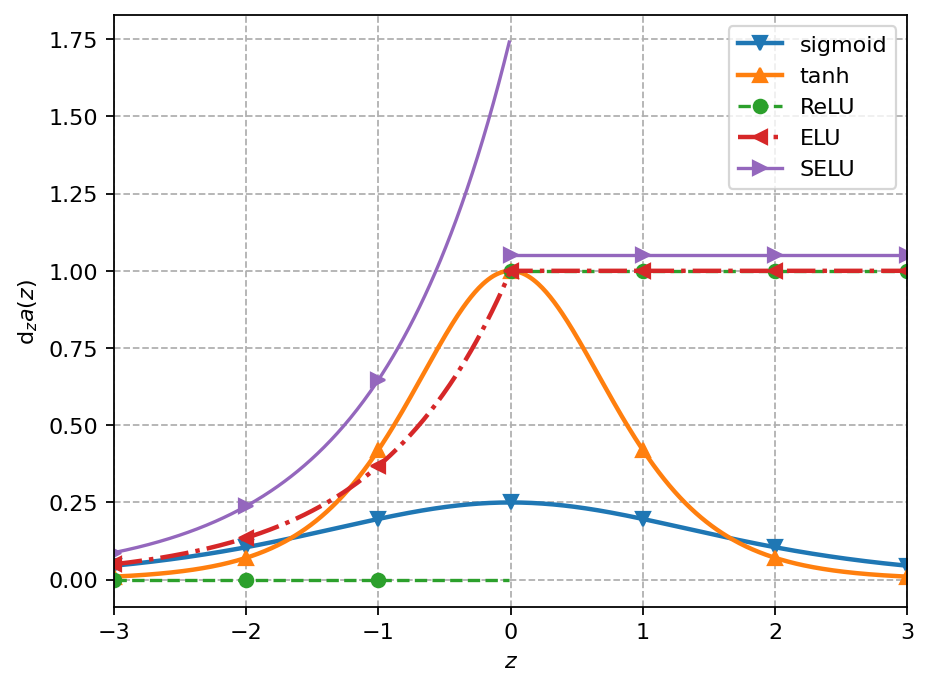

In [126]:
x = pt.arange(-3, 3.01, 0.01, requires_grad=True)
marker = ["v", "^", "o", "<", ">"]
ls = ["-", "-", "--", "-.", "-"]
cont = [True, True, False, True, False]
color = ["C{:1d}".format(i) for i in range(len(activations))]
for i, (name, func) in enumerate(activations.items()):
    res = func()(x)
    res.backward(pt.ones(x.shape[0]))
    x_num = x.detach().numpy()
    grad_num =  x.grad.numpy()
    if cont[i]:
        plt.plot(x_num, grad_num,
            ls=ls[i], lw=2, marker=marker[i], markevery=100, color=color[i], label=name)
    else:
        plt.plot([xi for xi in x_num if xi <= 0.0], [dx for xi, dx in zip(x_num, grad_num) if xi <= 0.0],
                ls=ls[i], marker=marker[i], markevery=100, color=color[i], label=name)
        plt.plot([xi for xi in x_num if xi > 0.0], [dx for xi, dx in zip(x_num, grad_num) if xi > 0.0],
                ls=ls[i], marker=marker[i], color=color[i], markevery=100)
    x.grad.data.zero_()
    
plt.xlim(-3,3)
plt.xlabel(r"$z$")
plt.ylabel(r"$\mathrm{d}_za(z)$")
plt.grid(True, ls="--")
plt.legend()
plt.savefig(f"{output}/activation_slopes.svg", bbox_inches="tight")

In [127]:
results_act = {}
models_act = {}
train_loader = pt.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

for key, act in activations.items():
    model = create_simple_network(2, 1, 50, 2, act)
    optimizer = optimizer=pt.optim.AdamW(model.parameters(), lr=0.01)
    scheduler = pt.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", factor=0.5, patience=20, min_lr=1.0e-4)
    results_act[key] = train_model(
        model,
        pt.nn.MSELoss(),
        train_loader, val_loader, test_loader,
        epochs=500,
        lr_schedule=scheduler,
        optimizer=optimizer
    )
    models_act[key] = deepcopy(model)

 Epoch  499/499 - Training loss: 5.979562e-05; Validation loss: 5.140446e-05; Test loss: 7.680662e-05

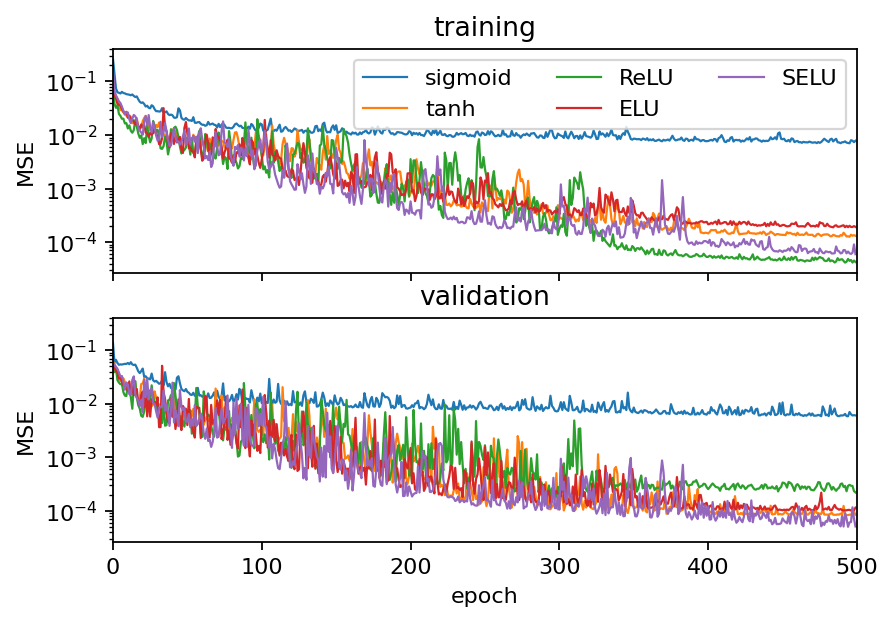

In [128]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 4), sharex=True, sharey=True)
for i, (key, res) in enumerate(results_act.items()):
    ax1.plot(res["epoch"], res["train_loss"], lw=1, label=f"{key}")
    ax2.plot(res["epoch"], res["val_loss"], lw=1, label=f"{key}")

ax1.set_title("training")
ax2.set_title("validation")
ax2.set_xlabel("epoch")
for ax in (ax1, ax2):
    ax.set_ylabel("MSE")
    ax.set_yscale("log")
ax1.set_xlim(0, 500)
ax1.legend(ncol=3)
plt.savefig(join(output, "activations_plateau_bs128_lecture_4.svg"), bbox_inches="tight")
plt.show()

The plot below shows the model employing hyperbolic tangents activations. The accuracy is improved even further. Moreover, all profiles are significantly smoother.

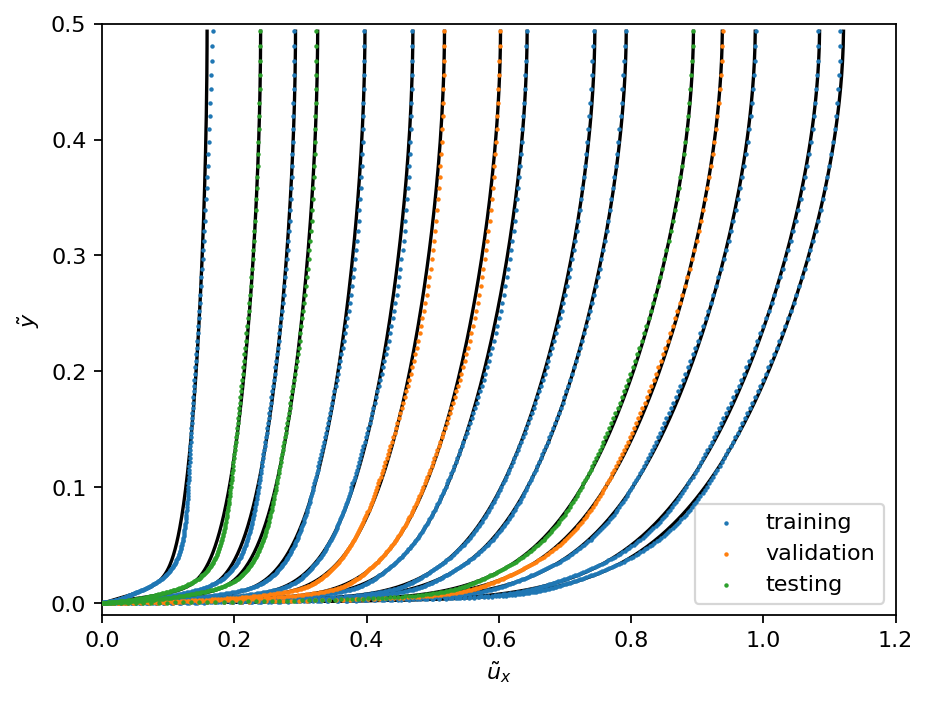

In [129]:
model = models_act["tanh"]
pred_train = make_prediction(model, train_tensor[:, 1:], feature_scaler, label_scaler)
pred_val = make_prediction(model, val_tensor[:, 1:], feature_scaler, label_scaler)
pred_test = make_prediction(model, test_tensor[:, 1:], feature_scaler, label_scaler)


n_points = len(y)
for i in range(len(Re)):
    plt.plot(u_x[:, i]/Ubar.max(), y/(2*delta), ls="-", c="k")
plt.scatter(pred_train, train_tensor[:, 1], s=1, c="C0", zorder=6, label="training")
plt.scatter(pred_val, val_tensor[:, 1], s=1, c="C1", zorder=6, label="validation")
plt.scatter(pred_test, test_tensor[:, 1], s=1, c="C2", zorder=6, label="testing")
plt.xlabel(r"$\tilde{u}_x$")
plt.ylabel(r"$\tilde{y}$")
plt.xlim(0.0, 1.2)
plt.ylim(-0.01, 0.5)
plt.legend()
plt.savefig(join(output, "prediction_act_lecture_4.svg"), bbox_inches="tight")
plt.show()

### Advanced building blocks

In the next cells, we test a few advanced network building blocks, namely:
- normalization: normalization layers aim to improve learning by re-scaling the output of the precessing layer; batch normalization learns normalization across batches, while layer normalization learns normalizing the neuron output within a layer
- skip connections: skipping connections means that the input of an early layer in the network is also provided to layer following later, thereby skipping one or more layers in-between; the inputs are merged by concatenation
- residual blocks: similar to skip connections, residual blocks merge the input of a layer with its output; however, the input for the next layer is created by addition instead of concatenation

In [18]:
def create_normalized_network(n_in: int, n_out: int, n_neurons: int,
    n_hidden: int, activation: pt.nn.Module, layer_norm: bool = False
    ) -> pt.nn.Sequential:
    if layer_norm:
        norm_layer, norm_size = pt.nn.LayerNorm, [n_neurons]
    else:
        norm_layer, norm_size = pt.nn.BatchNorm1d, n_neurons
    layers = [
        pt.nn.Linear(n_in, n_neurons),
        activation(),
        norm_layer(norm_size)
    ]
    for _ in range(n_hidden):
        layers.append(pt.nn.Linear(n_neurons, n_neurons))
        layers.append(activation())
        layers.append(norm_layer(norm_size))
    layers.append(pt.nn.Linear(n_neurons, n_out))
    return pt.nn.Sequential(*layers)

In [19]:
class SkipBlock(pt.nn.Module):
    def __init__(self, n_in: int, n_out: int, activation: pt.nn.Module = pt.nn.Tanh,
                 norm: str = None):
        super(SkipBlock, self).__init__()
        self._layer_1 = pt.nn.Linear(n_in, n_in)
        self._layer_2 = pt.nn.Linear(2*n_in, n_out)
        if norm == "batch":
            self._norm_1 = pt.nn.BatchNorm1d(n_in)
            self._norm_2 = pt.nn.BatchNorm1d(n_out)
        elif norm == "layer":
            self._norm_1 = pt.nn.LayerNorm([n_in])
            self._norm_2 = pt.nn.LayerNorm([n_out])
        else:
            self._norm_1 = pt.nn.Identity()
            self._norm_2 = pt.nn.Identity()
        self._activation = activation()

    def forward(self, x):
        h = self._norm_1(self._activation(self._layer_1(x)))
        x = pt.cat([x, h], dim=1)
        return self._norm_2(self._activation(self._layer_2(x)))

In [20]:
def create_skip_network(n_in: int, n_out: int, n_neurons: int, n_hidden: int,
                       activation: pt.nn.Module, norm: str = None) -> pt.nn.Sequential:
    layers = [
        SkipBlock(n_in, n_neurons, activation, norm)
    ]
    for _ in range(n_hidden):
        layers.append(SkipBlock(n_neurons, n_neurons, activation, norm))
    layers.append(pt.nn.Linear(n_neurons, n_out))
    return pt.nn.Sequential(*layers)

In [21]:
class ResidualBlock(pt.nn.Module):
    def __init__(self, n_in: int, n_out: int, activation: pt.nn.Module, norm: str = None):
        super().__init__()
        layers = [pt.nn.Linear(n_in, n_out)]
        layers.append(activation())
        if norm == "batch":
            layers.append(pt.nn.BatchNorm1d(n_out))
        elif norm == "layer":
            layers.append(pt.nn.LayerNorm([n_out]))
        self.F = pt.nn.Sequential(*layers)

    def forward(self, x):
        return x + self.F(x)

In [22]:
def create_res_network(n_in: int, n_out: int, n_neurons: int, n_hidden: int,
                       activation: pt.nn.Module, norm: str = None) -> pt.nn.Sequential:
    layers = [
        pt.nn.Linear(n_in, n_neurons),
        activation()
    ]
    for _ in range(n_hidden):
        layers.append(ResidualBlock(n_neurons, n_neurons, activation, norm))
    layers.append(pt.nn.Linear(n_neurons, n_out))
    return pt.nn.Sequential(*layers)

In [135]:
def generate_advanced_models():
    return {
        "ref." : create_simple_network(2, 1, 50, 2, pt.nn.Tanh),
        "batch norm." : create_normalized_network(2, 1, 50, 2, pt.nn.Tanh, False),
        "layer norm." : create_normalized_network(2, 1, 50, 2, pt.nn.Tanh, True),
        "skip conn." : create_skip_network(2, 1, 50, 2, pt.nn.Tanh, None),
        "skip conn., layer norm." : create_skip_network(2, 1, 50, 2, pt.nn.Tanh, "layer"),
        "res. block" : create_res_network(2, 1, 50, 2, pt.nn.Tanh, None),
        "res. block, layer norm." : create_res_network(2, 1, 50, 2, pt.nn.Tanh, "layer")
    }

In [136]:
results_adv = {}
train_loader = pt.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
for key, model in generate_advanced_models().items():
    optimizer = optimizer=pt.optim.AdamW(model.parameters(), lr=0.01)
    scheduler = pt.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", factor=0.5, patience=20, min_lr=1.0e-4)
    results_adv[key] =  train_model(model, pt.nn.MSELoss(), train_loader, val_loader, test_loader,
                                    epochs=500, lr_schedule=scheduler, optimizer=optimizer)

 Epoch  499/499 - Training loss: 5.116301e-05; Validation loss: 2.753079e-05; Test loss: 5.703035e-05

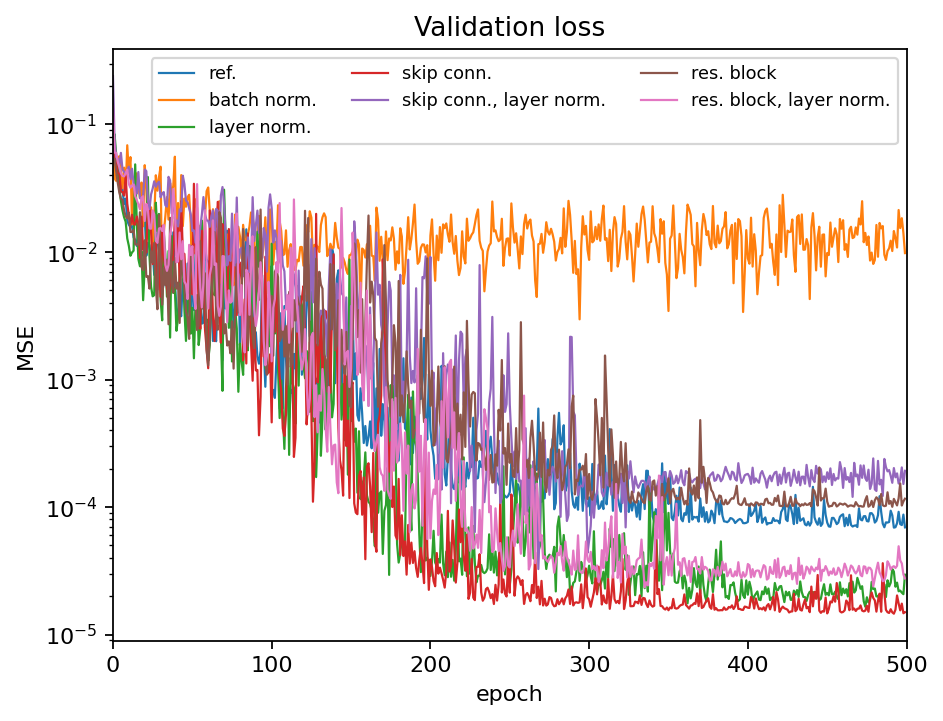

In [137]:
for key, res in results_adv.items():
    plt.plot(res["epoch"], res["val_loss"], lw=1, label=key)

plt.title("Validation loss")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.yscale("log")
plt.xlim(0, 500)
plt.legend(ncol=3, fontsize=8)
plt.savefig(join(output, "adv_networks_lecture_4.svg"), bbox_inches="tight")
plt.show()

### Dealing with uncertainty

The training of neural networks is not deterministic. If you go back to any cell in which the model training was performed and execute the cell several times, every time you will end up with a different model and a different loss behavior. The reason for this observation is twofold:

1. the loss function is non-convex
2. the initial network parameters are sampled randomly

Basically, we end up in different local minima in each training run. Fortunately, the situation is not as bad as it seems, because neural networks tend to have many local minima yielding good models. Nonetheless, if we want to rigorously compare two different neural networks, we have to deal with the uncertainty of the training as we would it in a real experiment. We repeat the training several times and compare different models on a statistical basis, e.g., by comparing mean, median, or standard deviation over all runs. In the example below, we compare several network designs based on the best $L_2$ loss. To keep the training time reasonable each training is repeated ten times.

In [138]:
n_repeat = 10
results_repeat = defaultdict(list)
for i in range(n_repeat):
    pt.manual_seed(i)
    for key, model in generate_advanced_models().items():
        optimizer = optimizer=pt.optim.AdamW(model.parameters(), lr=0.01)
        scheduler = pt.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", factor=0.5, patience=20, min_lr=1.0e-4)
        results_repeat[key].append(train_model(model, pt.nn.MSELoss(), train_loader, val_loader, test_loader,
                                   epochs=500, lr_schedule=scheduler, optimizer=optimizer))

 Epoch  499/499 - Training loss: 5.767075e-05; Validation loss: 6.188699e-05; Test loss: 3.591628e-05

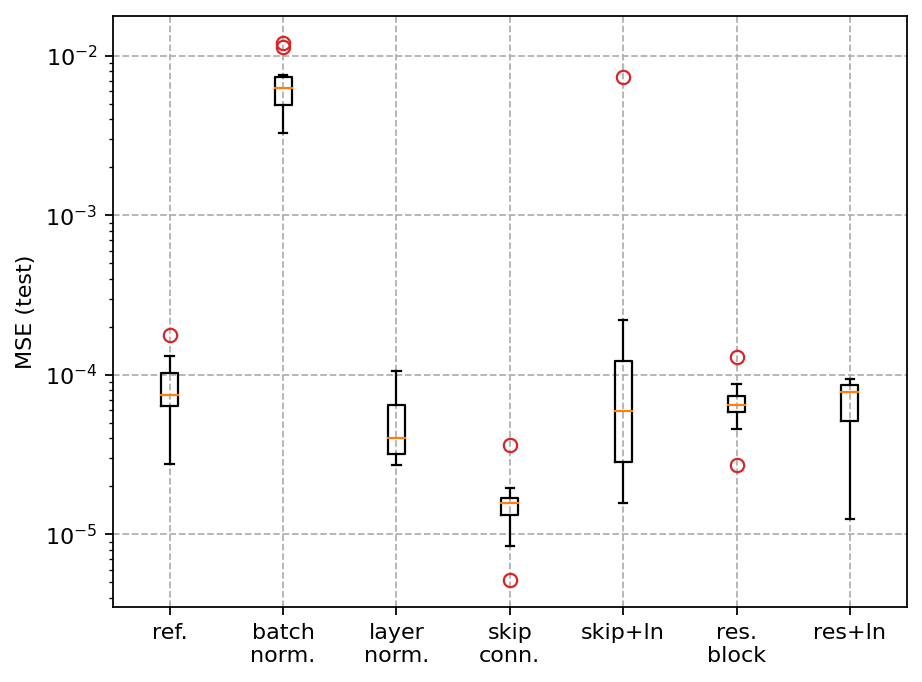

In [139]:
for i, key in enumerate(results_repeat.keys()):
    test_loss = np.asarray(
        [res["test_loss"].values[-10:].mean() for res in results_repeat[key]]
    )
    plt.boxplot(test_loss, positions=[i], flierprops={
                "markersize": 6, "markeredgecolor": "C3"})
plt.gca().set_xticklabels(("ref.", "batch\nnorm.", "layer\nnorm.", "skip\nconn.", "skip+ln", "res.\nblock", "res+ln"))
plt.yscale("log")
plt.ylabel("MSE (test)")
plt.grid(ls="--")
plt.savefig(join(output, "uncertainty_arch_lecture_4.svg"), bbox_inches="tight")
plt.show()

[Box plots](https://en.wikipedia.org/wiki/Box_plot) present a very rich visualization of groups of data. In the figure above, we compare the box plots resulting from the different network architectures. Box plots mainly work with quantiles. The $p$th quantile, denoted by $q_p$, is obtained by sorting the data and then counting through the data until $p\%$ of the overall number of data points are reached. For example, the $50$ th quantile of the set $\{ 3, 1, 5, 4, 2\}$ would be $q_{50} = 2$. The $50\%$ quantile is commonly called median. In a box plot, the lower and upper boundaries of the box are given by the $25$th and $75$th quantiles, respectively. The orange line in the plot below indicates the median. Quantiles are also used to identify outliers. The inter quantile range (IQR) is defined as $q_r = q_{75} - q_{25}$. Outlier detection based on the IQR assumes that values in the range $q_{25}-kq_r \le x \le q_{75}+kq_r$ are regular values, whereas values outside this range are outliers. The factor $k$ is often chosen as $k=1.5$. Outliers in the plot below are indicated by red circles. The so-called whiskers (the little antennas extending from the box) indicate the largest and smallest values not considered to be outliers. From box plots, we can infer the spread of the data and also how it is distributed. For example, if the whiskers are symmetric and the median is in the middle of the box, the data are normally distributed (approximately).

In ML research, we want our experiments to be repeatable, even if random sampling is part of the process. Luckily, there are no true random numbers in computer programs. Instead, they are said to be *pseudo random*, because we can define a so-called *seed* parameter that makes the sampling repeatable. In the loop of the code cell above, we use the loop count as seed. Therefore, the initial weights change for each training run in a repeatable manner.

An important design parameter to change the model's flexibility (the ability to fit data) is the number of hidden layers. In the code cell below, we conduct a similar experiment as before but vary only the number of hidden layers. As can be seen in the box plots, the loss and also the spread of the loss decreases significantly as the number of hidden layers increases. Moreover, the improvement in the $L_2$ loss seems to become smaller and smaller with each additional hidden layers.

### Visualizing prediction errors

As mentioned before, it is relatively easy to assess the model's behavior for the present problem. For high-dimensional parameter spaces, the evaluation is less straightforward, and we have to rely on statistics and other less intuitive means of visualization. Two techniques are demonstrated below:

- a histogram of the prediction error; the histogram shows how the error is distributed; ideally, all prediction errors should be located in a narrow band around zero; we can immediately read the maximum prediction errors and infer how many predictions yield such high errors
- a heatmap with the maximum prediction errors in different sub-sections of the feature space; if we had more features, we would create the same plot for the two most important features, or we would create several heatmaps for different combinations of features; the heatmap indicates which sections of the feature space yield high prediction errors; in the example below we see that prediction errors are high for small distances and large Reynolds numbers

In [140]:
final_model = create_skip_network(2, 1, 50, 2, pt.nn.Tanh)
optimizer = optimizer=pt.optim.AdamW(final_model.parameters(), lr=1.0e-2)
scheduler = pt.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", factor=0.5, patience=20, min_lr=1.0e-4)
final_results = train_model(final_model, pt.nn.MSELoss(), train_loader, val_loader, test_loader,
                            epochs=500, lr_schedule=scheduler, optimizer=optimizer)

 Epoch  499/499 - Training loss: 8.186048e-06; Validation loss: 6.622953e-06; Test loss: 7.083297e-06

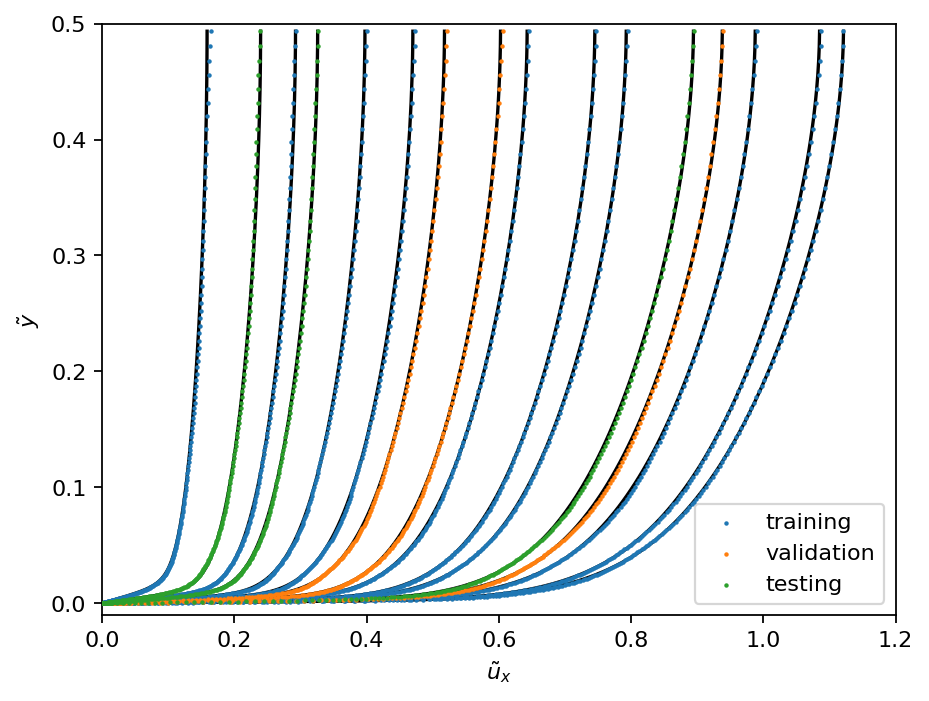

In [142]:
pred_train_final = make_prediction(final_model, train_tensor[:, 1:], feature_scaler, label_scaler)
pred_val_final = make_prediction(final_model, val_tensor[:, 1:], feature_scaler, label_scaler)
pred_test_final = make_prediction(final_model, test_tensor[:, 1:], feature_scaler, label_scaler)


n_points = len(y)
for i in range(len(Re)):
    plt.plot(u_x[:, i]/Ubar.max(), y/(2*delta), ls="-", c="k")
plt.scatter(pred_train_final, train_tensor[:, 1], s=1, c="C0", zorder=6, label="training")
plt.scatter(pred_val_final, val_tensor[:, 1], s=1, c="C1", zorder=6, label="validation")
plt.scatter(pred_test_final, test_tensor[:, 1], s=1, c="C2", zorder=6, label="testing")
plt.xlabel(r"$\tilde{u}_x$")
plt.ylabel(r"$\tilde{y}$")
plt.xlim(0.0, 1.2)
plt.ylim(-0.01, 0.5)
plt.legend()
plt.savefig(join(output, "final_prediction_lecture_4_model_pl.svg"), bbox_inches="tight")
plt.show()

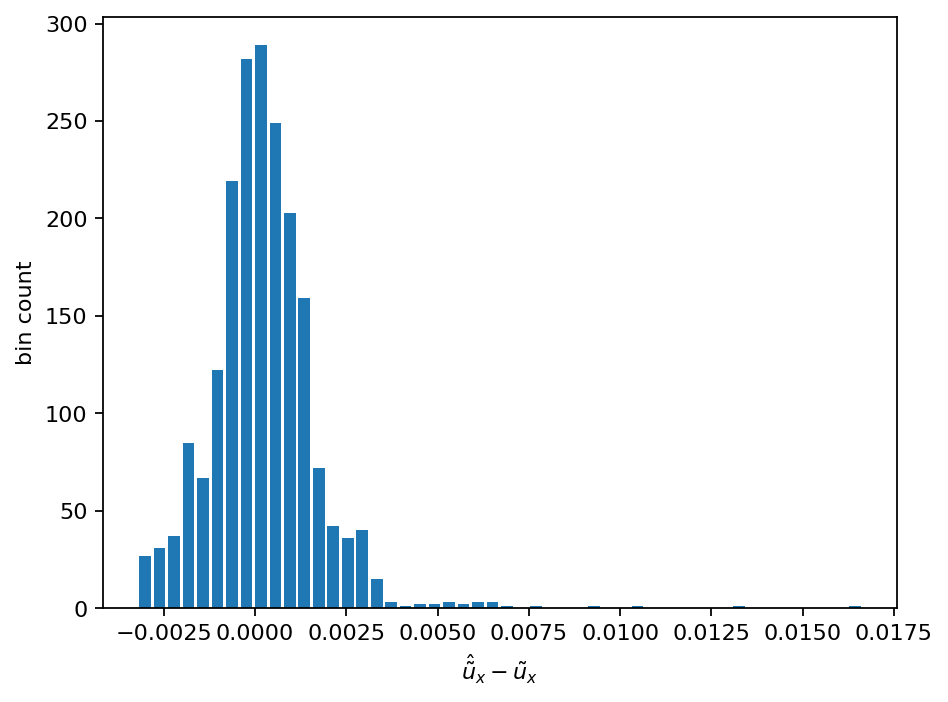

In [143]:
deviation = pred_train_final - train_tensor[:, 0]
dev_min, dev_max = deviation.min().item(), deviation.max().item()
counts = pt.histc(deviation, bins=50, min=dev_min, max=dev_max).detach()
bin_width = (dev_max-dev_min) / 50
centers = pt.arange(dev_min+0.5*bin_width, dev_min +
                    50*bin_width, bin_width).detach()

plt.bar(centers, counts, width=bin_width*0.8)
plt.xlabel(r"$\hat{\tilde{u}}_x - \tilde{u}_{x}$")
plt.ylabel("bin count")
plt.savefig(f"{output}/profile_error_hist.svg", bbox_inches="tight")

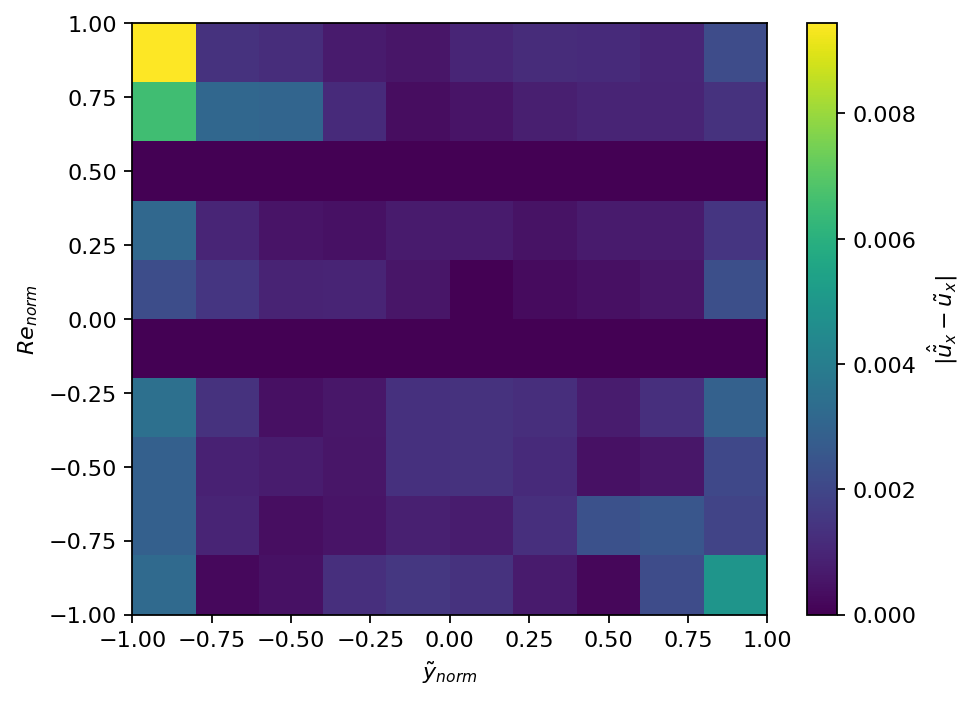

In [144]:
def max_error_map(x: pt.Tensor, err: pt.Tensor, bins: int) -> pt.Tensor:
    """Divide feature space in bins and compute maximum error for each bin.

    :param x: feature tensor
    :type x: pt.Tensor
    :param err: absolute error values
    :type err: pt.Tensor
    :param bins: number of bin
    :type bins: int
    :return: 2D tensor with maximum errors for each bin; if there are N bins,
        the result will be a NxN tensor
    :rtype: pt.Tensor
    """
    step = 2.0 / bins
    bounds_low = pt.arange(-1, 1.0, step)
    bounds_up = pt.arange(-1+step, 1.0+0.5*step, step)
    max_error = pt.zeros((bins, bins))
    for i, (low_i, up_i) in enumerate(zip(bounds_low, bounds_up)):
        for j, (low_j, up_j) in enumerate(zip(bounds_low, bounds_up)):
            errors = pt.where((x[:, 0] >= low_i) & (x[:, 1] >= low_j) & (
                x[:, 0] < up_i) & (x[:, 1] < up_j), err.type(pt.float64), 0.0)
            max_error[i, j] = errors.max()
    return max_error


error_map = max_error_map(feature_scaler.scale(train_tensor[:, 1:]), deviation.abs(), 10)
edges = pt.linspace(-1, 1, 10+1)
xx, yy = pt.meshgrid(edges, edges, indexing="ij")
pcol = plt.pcolormesh(xx.detach(), yy.detach(), error_map.detach())
plt.colorbar(pcol, label=r"$|\hat{\tilde{u}}_x - \tilde{u}_{x}|$")
plt.xlabel(r"$\tilde{y}_{norm}$")
plt.ylabel(r"$Re_{norm}$")
plt.savefig(join(output, "profile_error_heatmap.svg"), bbox_inches="tight")
plt.show()